### Loading Dataset

In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(SummarizedExperiment))

saveDir <- "environment/real_datasets/GSE100505_EDL_MAST/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/DE"
load(file.path(saveDir, "tseConsUp.RData"))
load(file.path(saveDir, "bSwishCons_OL.RData"))
treeCons <- rowTree(tseConsUp)
l <- length(treeCons$tip)

#### Transcript level analysis

In [2]:
metaData <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/SRR_Acc_List.txt")
quantDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/sal_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
samples <- metaData$RUN
files <- file.path(quantDir, samples, "quant.sf")
colData <- cbind(data.frame(files = files, names = samples), condition = as.factor(metaData$TissueName))
seMuscle <- tximeta::tximeta(colData)

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Mus musculus - release M25 ]

loading existing TxDb created: 2023-02-17 18:26:37

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-02-17 18:26:39

fetching genome info for GENCODE



In [3]:
y <- fishpond::scaleInfReps(tseConsUp[1:l,])
y <- labelKeep(y)
set.seed(10)
y <- swish(y, x="condition")

In [4]:
getLog2FC <- function(infRepsArray, condition, pc = 5) {
  dims <- dim(infRepsArray)
  cond1 <- condition == levels(condition)[1]
  cond2 <- condition == levels(condition)[2]
  diffs <- matrix(nrow = dims[1], ncol = dims[3])
  for (k in seq_len(dims[3])) {
    diffs[, k] <-
      log2(rowMeans(infRepsArray[, cond2, k]) + pc) - log2(rowMeans(infRepsArray[
        ,
        cond1, k
      ]) + pc)
  }

  # median over inferential replicates
  rowMedians(diffs)
}

In [5]:
yAll <- computeSizeFactors(tseConsUp)
yAll <- scaleInfReps(yAll)
yAll <- labelKeep(yAll)
set.seed(10)
yInn <- swish(yAll[(l+1):nrow(yAll),], x="condition")

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

In [6]:
infRepInds <- grep("infRep", assayNames(yAll))
infReps <- assays(yAll)[infRepInds]
infReps <- abind::abind(as.list(infReps), along = 3)
mcols(yAll)[["log2FC"]] <- getLog2FC(infReps, colData(yAll)[["condition"]])

In [7]:
pvals <- c(mcols(y)[["pvalue"]], mcols(yInn)[["pvalue"]])
adjust <- p.adjust(pvals, "BH")
mcols(yAll)[["qvalue"]] <- adjust

##### Differentially Expressed Transcripts

In [18]:
sapply(c(0.01,0.05,0.1), function(x) sum(mcols(y)[["qvalue"]] <= x, na.rm=T))
dTxps <- lapply(c(0.01,0.05,0.1), function(x) rownames(y)[which(mcols(y)[["qvalue"]] <= x)])
# save(dTxps, file=file.path(saveDir, "dTxps.RData"))

[1] 3149 6849 9592

##### Genes Mapping to those transcripts

In [19]:
mapDf <- rowData(seMuscle)
txpGenes <- lapply(dTxps, function(txps) unique(unlist(mapDf[txps, "gene_id"])))##Genes that map to transcripts
sapply(txpGenes, length)

[1] 2685 5391 7121

#### Gene Level

In [27]:
gse <- summarizeToGene(seMuscle)
yg <- fishpond::scaleInfReps(gse)
yg <- labelKeep(yg)
set.seed(10)
yg <- swish(yg, x="condition")

loading existing TxDb created: 2023-02-17 18:26:37

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2023-02-21 05:37:24

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



##### Differentially expressed genes

In [28]:
dges <- lapply(c(0.01,0.05,0.1), function(x) rownames(yg)[which(mcols(yg)[["qvalue"]] <= x)])
sapply(dges, length)
# save(dges, file=file.path(saveDir, "dges.RData"))

[1] 2535 4494 5814

##### Genes that are considered differentially expressed in genes but dont contain a single differentially expressed transcript

In [ ]:
diffGenes <- lapply(seq_along(dges), function(i) setdiff(dges[[i]], txpGenes[[i]])) ## Txps that are missing in differential transcripts mapping to genes
sapply(diffGenes, length)
diffGenes2 <- lapply(seq_along(dges), function(i) setdiff(txpGenes[[i]], dges[[i]])) ## Txps that are missing in differential transcripts mapping to genes                    
sapply(diffGenes2, length)
# sum(mcols(y)[unlist(mcols(yg)[diffGenes[[2]],"tx_ids"]), "qvalue"] < 0.05, na.rm=T)==0 ## None of the diffGenes should contain a differential transcript

#### Terminus

In [13]:
termFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old/SRR5758630/clusters.txt"
suppressPackageStartupMessages(source("old_terminus_helper.R"))
yTermThrNS <- tseConsUp[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepOSwish(yTermThrNS, mInds, groupsClust)
yTerm <- yAggTermThrNS[-unlist(groupsClust),]
yTerm <- fishpond::scaleInfReps(yTerm)
yTerm <- labelKeep(yTerm)
set.seed(10)
yTerm <- swish(yTerm, x="condition")

#### TreeDE, with the total number of nodes, inner nodes and their height distribution

In [10]:
load(file.path(saveDir, "treeDEFDR_OL.RData"))
treeDE <- treeDEFDR_OL[["mIRV=0.4"]] ## renaming the treeDE variable

In [15]:
detNodes <- list()
detNodes[["Txps"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(y)[,"qvalue"] <= x ))
detNodes[["treeDEFDR_OL"]] <- lapply(treeDEFDR_OL[["mIRV=0.4"]], function(ta) ta)
detNodes[["treeClimbR"]] <- lapply(bSwish, function(sw) sw$output[sw$output$signal.node,][["node"]])
detNodes[["treeClimbRO"]] <- lapply(bSwish, function(sw) unlist(Descendants(treeCons,sw$output[sw$output$signal.node,][["node"]])))
detNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= x)]
        match(nodes, names(yAggTermThrNS))
    })
detNodes[["genes"]] <- dges

In [18]:
save(detNodes, file="treeDE_Paper_Images/mousemuscle/detNodes.RData")

In [14]:
sapply(treeDE, length) ## number of differentially expressed nodes
sapply(treeDE, function(nodes) sum(nodes > l)) ## number of inner nodes
lapply(treeDE, function(nodes) table(node.depth(treeCons,2)[nodes])) ## Distribution of node heights
lapply(detNodes[["treeClimbR"]], function(nodes) table(node.depth(treeCons,2)[nodes])) ## Distribution of node heights for treeclimbR

[1]  3711  7693 10458

[1] 1189 2287 2958

[[1]]

   1    2    3    4    5    6    7    8    9   10   11 
2522  651  295  134   59   28    8    7    4    1    2 

[[2]]

   1    2    3    4    5    6    7    8    9   10   11   13 
5406 1285  555  252  107   46   20   11    4    1    3    3 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
7500 1698  696  308  130   62   31   17    6    4    3    1    2 


[[1]]

   1    2    3    4    5    6    7    8    9   10   11 
2491  249   75   34   28   17    7    4    2    1    1 

[[2]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
5259  485  192   57   56   36   13    7    3    3    1    1    1 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
7449  580  231   76   61   39   15    9    4    3    1    1    1 


In [15]:
j <- 1
treeDETxps <- rownames(tseConsUp)[unlist(Descendants(treeCons, detNodes[["treeDEFDR_OL"]][[j]]))]
treeClimbTxps <- rownames(tseConsUp)[unlist(Descendants(treeCons, detNodes[["treeClimbR"]][[j]]))]

dN <- detNodes[["term"]][[j]]

termTxps <- c(rownames(yAggTermThrNS)[dN][startsWith(rownames(yAggTermThrNS)[dN], "ENS")],
  rownames(yAggTermThrNS)[as.numeric(unlist(groupsClust[rownames(yAggTermThrNS)[dN][!startsWith(rownames(yAggTermThrNS)[dN], "ENS")]]))])

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'yAggTermThrNS' not found


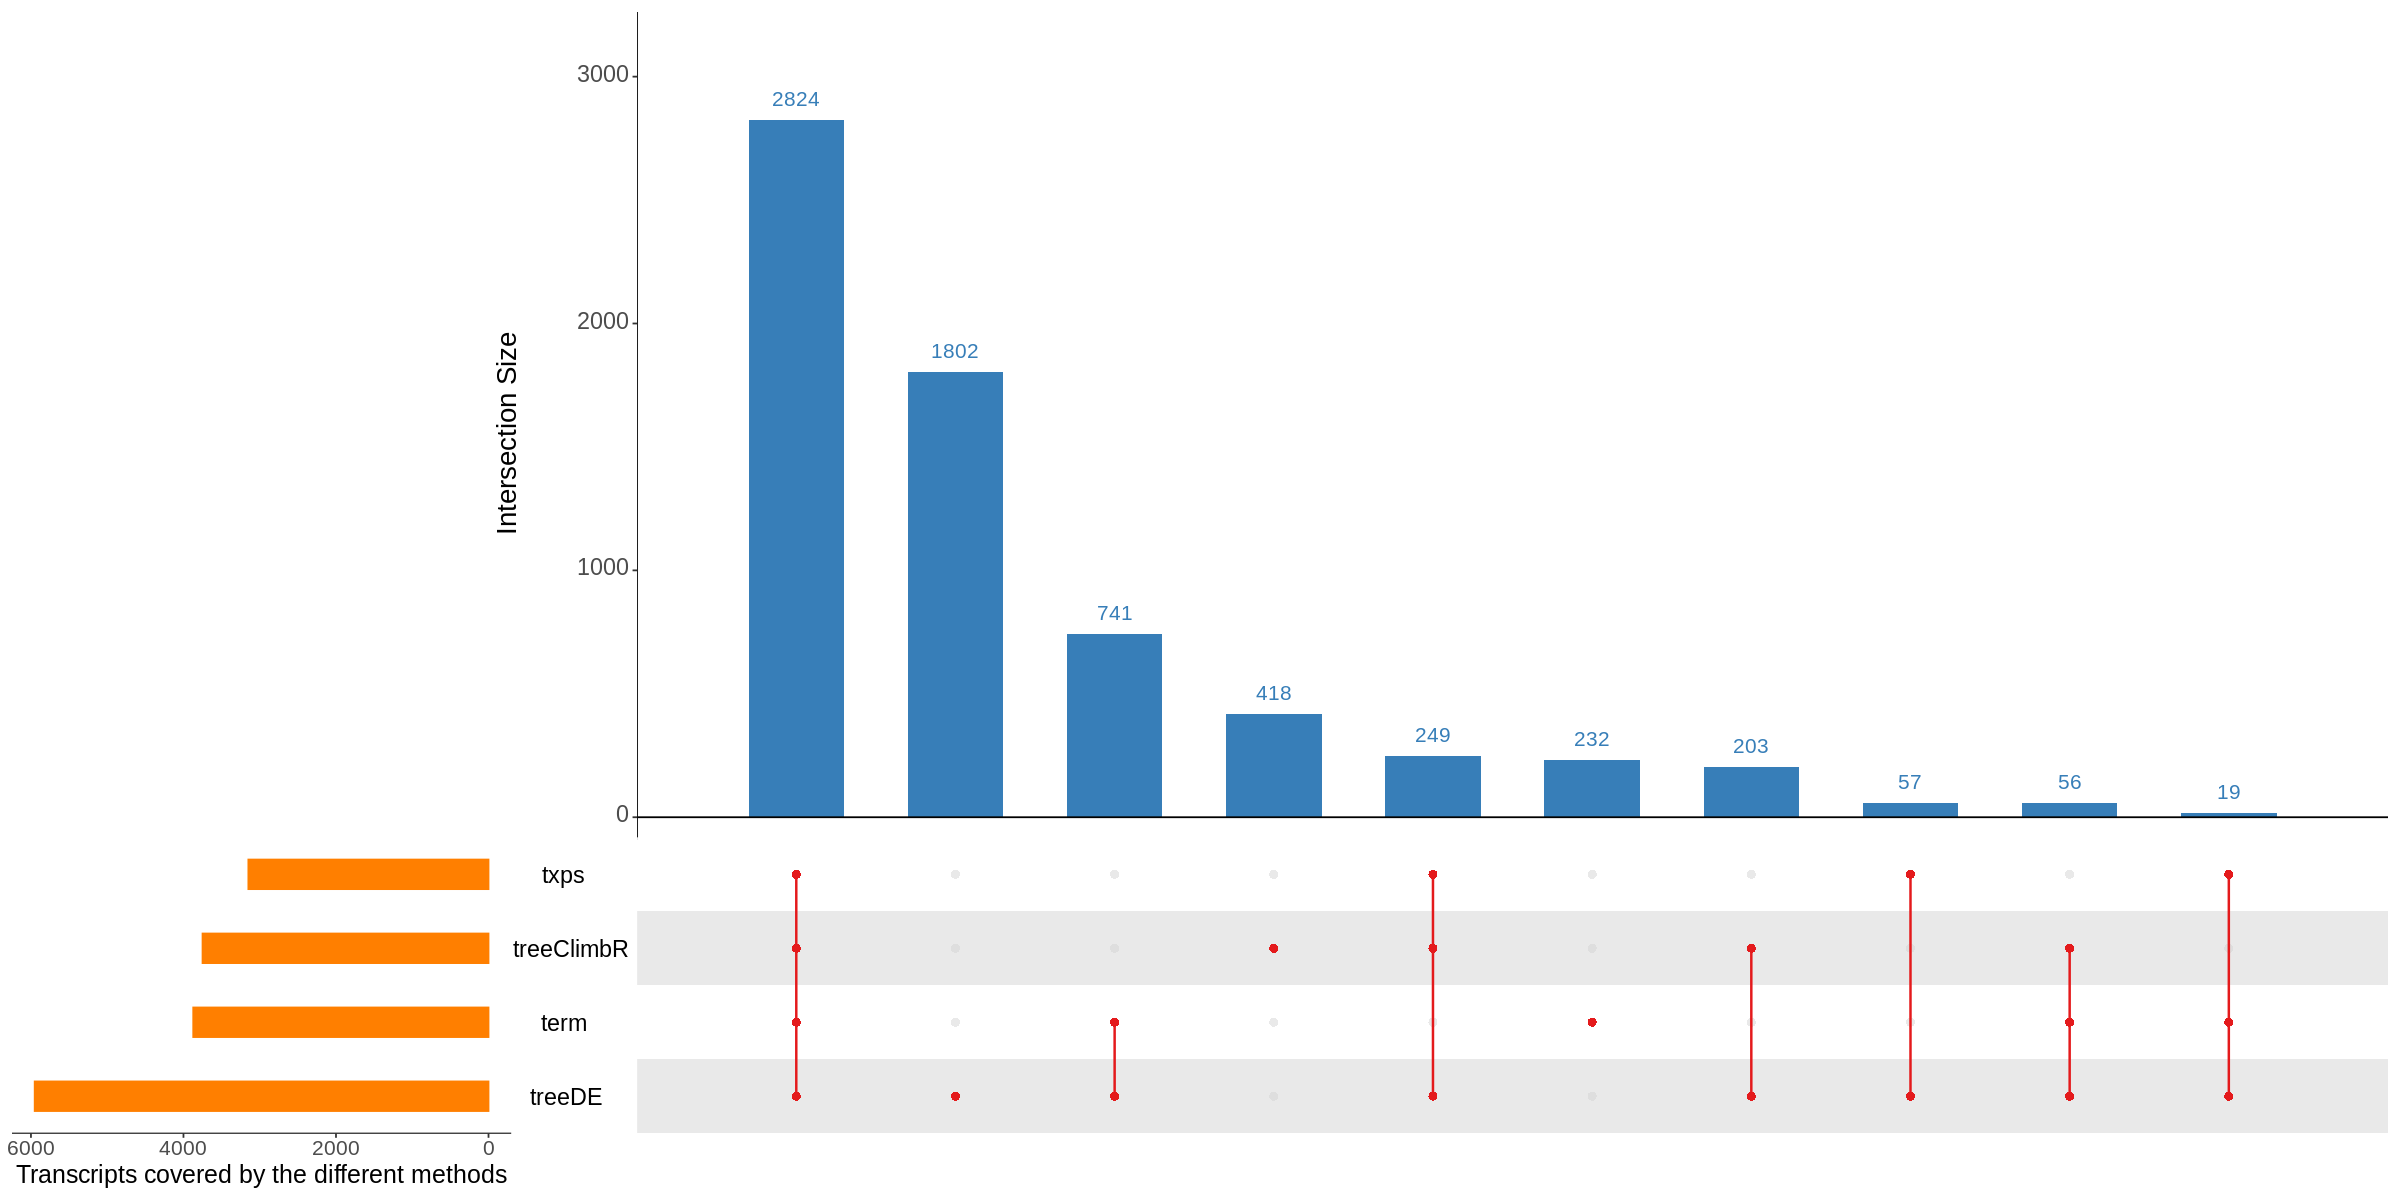

In [17]:
options(repr.plot.width=20, repr.plot.height=10)
suppressPackageStartupMessages(library(UpSetR))
txpMethods = list(txps = dTxps[[j]], 
                 treeDE = treeDETxps, 
                 treeClimbR = treeClimbTxps, 
                 term = termTxps)
upsetData <- fromList(txpMethods)
size <- 2
upset(upsetData, order.by = "freq",
     main.bar.color = "#377eb8", 
     matrix.color = "#e41a1c",
     sets.bar.color = c("#ff7f00"),
     sets.x.label = "Transcripts covered by the different methods",
     shade.alpha = 0.7, 
     text.scale = c(size, size, 1.8, 1.8, size, size)
)

##### Genes mapping to the treeClimbR nodes and their number

In [19]:
genesTCR <- lapply(detNodes[["treeClimbR"]], function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"gene_id"])))})
sapply(genesTCR, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesTCR, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 2731 5423 7117

[[1]]

   1    2    3    4    5    6    8 
2872   25    4    4    2    1    1 

[[2]]

   1    2    3    4    5    6    8   11 
6046   50    7    4    2    2    2    1 

[[3]]

   1    2    3    4    5    6    7    8   11 
8390   57   10    4    2    2    1    3    1 


##### Genes mapping to the treeDE nodes and their number

In [23]:
genesTreeDE <- lapply(treeDE, function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"gene_id"])))})
sapply(genesTreeDE, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesTreeDE, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 3255 6220 8010

[[1]]

   1    2    3    5 
3672   33    5    1 

[[2]]

   1    2    3    4 
7625   56    8    4 

[[3]]

    1     2     3     4     7     9 
10369    73     9     4     1     2 


#### Genes that map only to treeDE but are neither DE or covered by differential transcripts

In [29]:
### Nodes that dont cotain a DET
ll <- lapply(seq_along(treeDE), function(i) {
    desc <- Descendants(treeCons, treeDE[[i]])
    which(sapply(desc, function(txps) sum(txps %in% detNodes[["Txps"]][[i]]) == 0))
})

### Nodes that DO NOT contain a single DE gene
sapply(ll, length)
nodesNotDE <- lapply(seq_along(ll), function(i) {
    genesL <- genesTreeDE[[i]][ll[[i]]]
    ll[[i]][sapply(genesL, function(genes) sum(genes %in% dges[[i]]) == 0)]
})
sapply(nodesNotDE, length)

[1]  585  928 1009

[1] 231 382 390

Such inner nodes can be possible DTUs. We thus extract the treeDE nodes to which these genes map to and try to see if there are multiple such tree DE nodes that map to same gene.Looking at the 0.1 threshold change, we find only 1 gene for which a dtu on the inner nodes is observed.

For the remaining that have map to inner node, infRV decreases compared to their children though the logFC is lower compared to children. logFC though definitely decreases at gene.

In [30]:
qval <- 0.01
i <- 1
gg <- unlist(genesTreeDE[[i]][nodesNotDE[[i]]])
gN <- gg[which(mcols(yg)[gg,"qvalue"] > qval)]
length(gN) ## genes belonging to the unique treeDE nodes that have qvalue > 0.15 when doing gene level DE analysis

# extracting genes unique to treeDE and have logFC > 0.2 or have atleast two sig nodes
twoNodes <- list() 
lfcNodes <- c()
j <- 1
for(g in gN) {
    iid <- which(sapply(genesTreeDE[[i]], function(genes) sum(g %in%  genes) > 0))
    if(length(iid) > 1) {
        twoNodes[[j]] <- iid
        j <- j + 1
    }
    else if(length(which(abs(mcols(yAll)[treeDE[[i]][iid],"log2FC"]) > 0.2)) > 0) {
        lfcNodes <- c(lfcNodes, iid)
    }
}
length(twoNodes)
length(lfcNodes)

[1] 245

[1] 13

[1] 232

In [43]:
sum(sapply(twoNodes, function(tt) {
    print(length(tt))
    lf <- mcols(yAll)[treeDE[[i]][tt],"log2FC"]
    lf[1]*lf[2] < 0            
}))

[1] 2
[1] 2
[1] 3
[1] 3
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2


[1] 1

In [41]:
mcols(yg)[unlist(mapDf[treeCons$tip[treeDE[[i]][twoNodes[[4]]][2]],"gene_id"]),]
mcols(yAll)[treeDE[[i]][twoNodes[[4]]],]
mcols(yg)[unlist(mapDf[treeCons$tip[treeDE[[i]][twoNodes[[5]]][2]],"gene_id"]),]
mcols(yAll)[treeDE[[i]][twoNodes[[5]]],]

DataFrame with 1 row and 9 columns
                                    gene_id
                                <character>
ENSMUSG00000030795.18 ENSMUSG00000030795.18
                                                                                   tx_ids
                                                                          <CharacterList>
ENSMUSG00000030795.18 ENSMUST00000106251.9,ENSMUST00000077609.11,ENSMUST00000137464.6,...
                      log10mean      keep      stat    log2FC    pvalue
                      <numeric> <logical> <numeric> <numeric> <numeric>
ENSMUSG00000030795.18   3.54947      TRUE      8.08  0.187332  0.174088
                         locfdr    qvalue
                      <numeric> <numeric>
ENSMUSG00000030795.18         1  0.301114

DataFrame with 3 rows and 4 columns
                     meanInfRV log10mean      keep    log2FC
                     <numeric> <numeric> <logical> <numeric>
Node135498            0.292246   1.89700      TRUE  0.817463
ENSMUST00000121616.8  1.583670   2.93222      TRUE  0.842355
ENSMUST00000137464.6  3.065111   1.76171      TRUE -1.921770

DataFrame with 1 row and 9 columns
                                    gene_id
                                <character>
ENSMUSG00000038039.13 ENSMUSG00000038039.13
                                                                                   tx_ids
                                                                          <CharacterList>
ENSMUSG00000038039.13 ENSMUST00000057659.13,ENSMUST00000162984.1,ENSMUST00000162041.7,...
                      log10mean      keep      stat     log2FC    pvalue
                      <numeric> <logical> <numeric>  <numeric> <numeric>
ENSMUSG00000038039.13   2.91227      TRUE     -0.93 -0.0685823  0.875538
                         locfdr    qvalue
                      <numeric> <numeric>
ENSMUSG00000038039.13         1  0.923616

DataFrame with 2 rows and 4 columns
                     meanInfRV log10mean      keep    log2FC
                     <numeric> <numeric> <logical> <numeric>
Node141841            0.674866   2.74241      TRUE  0.614672
ENSMUST00000162965.1  1.739591   2.21942      TRUE -0.975061

##### DTU

In [49]:
##Follow up analysis
## (1,2) map to more than 1 gene
## 4,5,6 shows no dtu
twoNodes
for(j in seq_along(twoNodes)) {
    gs <- genesTreeDE[[i]][[twoNodes[[j]][1]]]
    genesTreeDE[[i]][[twoNodes[[j]][2]]]

    print("Gene Level")
    print(mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")])

    print("TreeDE Node 1")
    print(cbind(mcols(yAll)[treeDE[[i]][twoNodes[[j]][1]],], qval = adjust[treeDE[[i]][twoNodes[[j]][[1]]]]))
#     print("Transcripts mapping TreeDE Node 1")
#     print(cbind(mcols(yAll)[unlist(Descendants(treeCons,treeDE[[i]][twoNodes[[j]][1]])),], 
#           qval = adjust[unlist(Descendants(treeCons,treeDE[[i]][twoNodes[[j]][1]]))]))

    print("TreeDE Node 2")
    print(cbind(mcols(yAll)[treeDE[[i]][twoNodes[[j]][2]],],
         qval = adjust[treeDE[[i]][twoNodes[[j]][[2]]]]))
#     print("Transcripts mapping TreeDE Node 2")
#     print(cbind(mcols(yAll)[unlist(Descendants(treeCons,treeDE[[i]][twoNodes[[j]][2]])),], 
#           qval = adjust[unlist(Descendants(treeCons,treeDE[[i]][twoNodes[[j]][2]]))]))
    
    print("new")
}


[[1]]
[1] 6391 6392

[[2]]
[1] 6540 6543

[[3]]
[1] 8752 8753

[[4]]
[1] 9985 9986

[1] "Gene Level"
DataFrame with 3 rows and 3 columns
                      log10mean    log2FC    qvalue
                      <numeric> <numeric> <numeric>
ENSMUSG00000059005.13   3.75342  0.582774 0.0239884
ENSMUSG00000069014.4    2.43071  0.465375 0.7014601
ENSMUSG00000081205.4    1.12337        NA        NA
[1] "TreeDE Node 1"
DataFrame with 1 row and 6 columns
           meanInfRV log10mean      keep    log2FC    qvalue      qval
           <numeric> <numeric> <logical> <numeric> <numeric> <numeric>
Node142495   1.00929   3.42829      TRUE  0.554751 0.0274336 0.0274336
[1] "TreeDE Node 2"
DataFrame with 1 row and 6 columns
           meanInfRV log10mean      keep    log2FC     qvalue       qval
           <numeric> <numeric> <logical> <numeric>  <numeric>  <numeric>
Node142499  0.922514   3.47419      TRUE  0.606193 0.00147547 0.00147547
[1] "new"
[1] "Gene Level"
DataFrame with 2 rows and 3 columns
                     log10mean    log2FC     qvalue
                     <numeric>

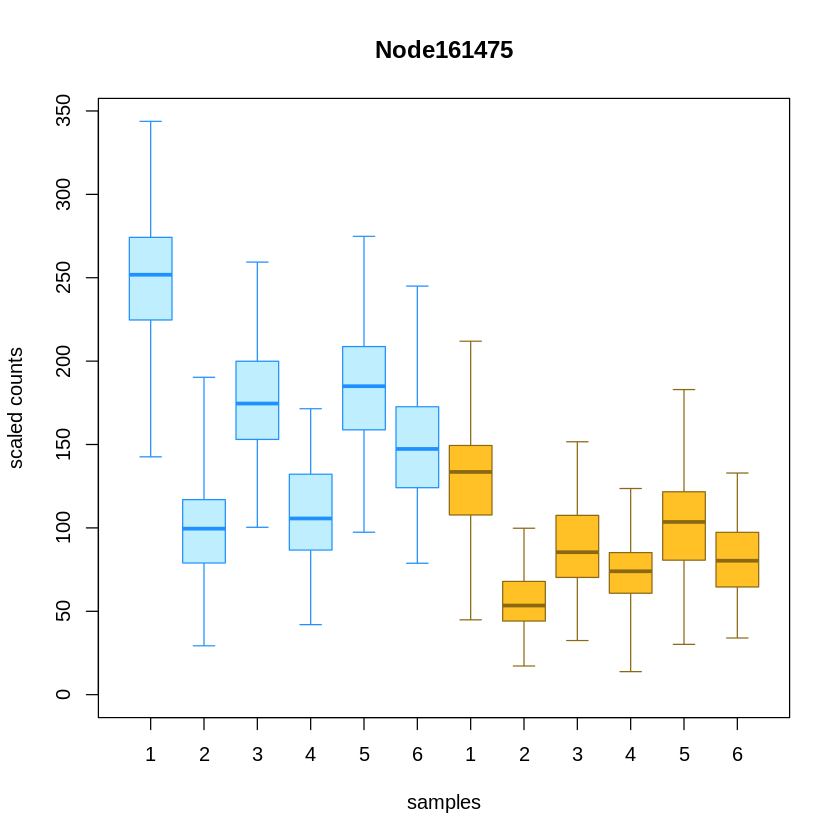

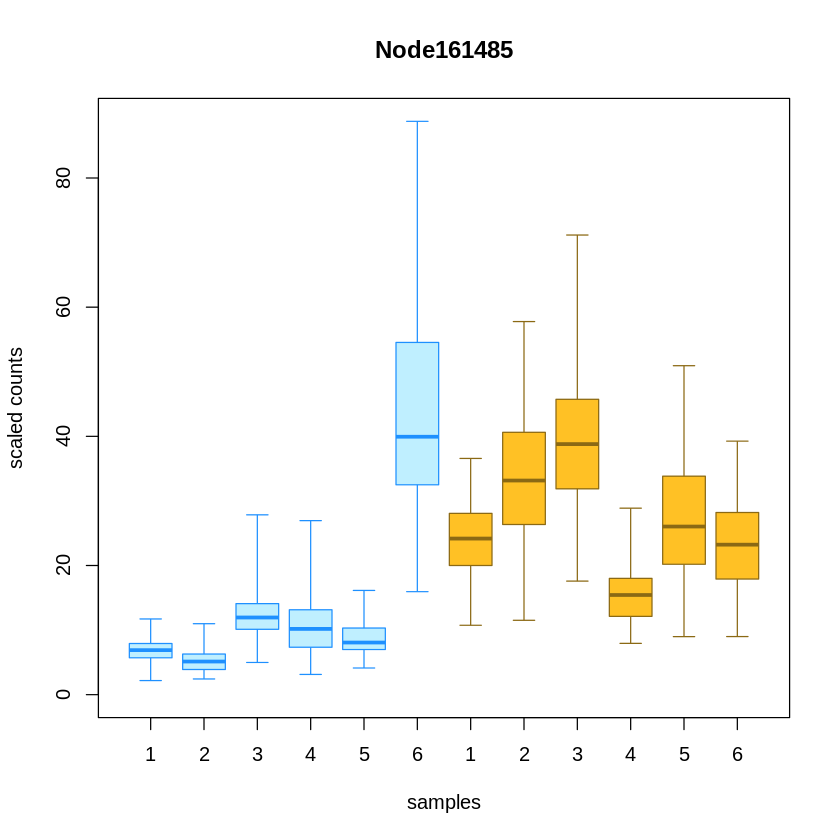

In [51]:
j <- 3
plotInfReps(y=yAll, x = "condition", idx = treeDE[[i]][twoNodes[[j]][1]])
plotInfReps(y=yAll, x = "condition", idx = treeDE[[i]][twoNodes[[j]][2]])

##### Other example of the above genes that however show no dtu

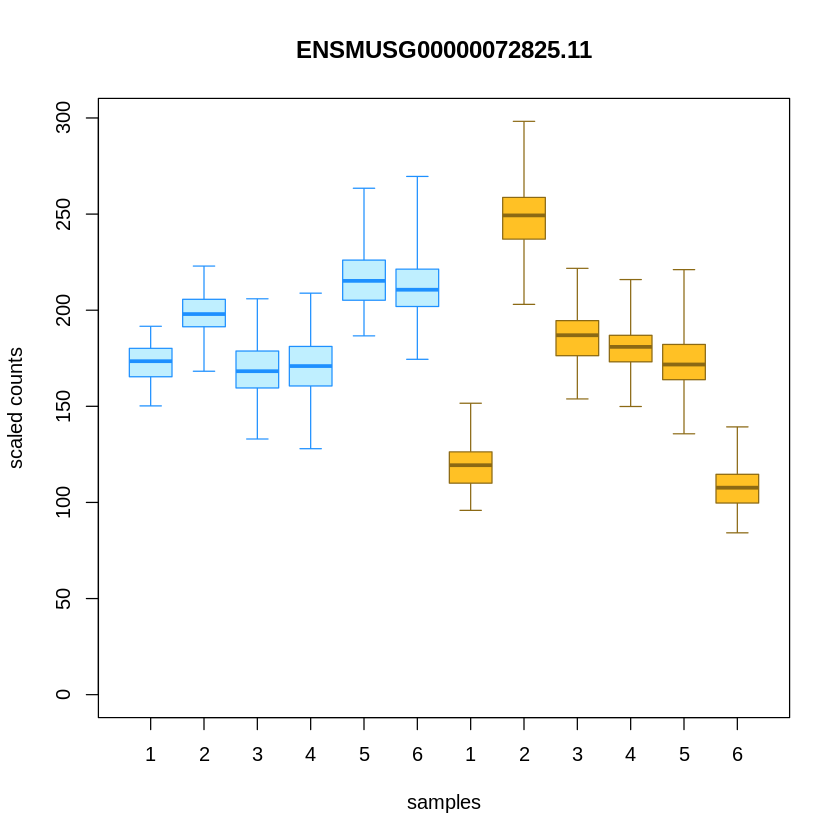

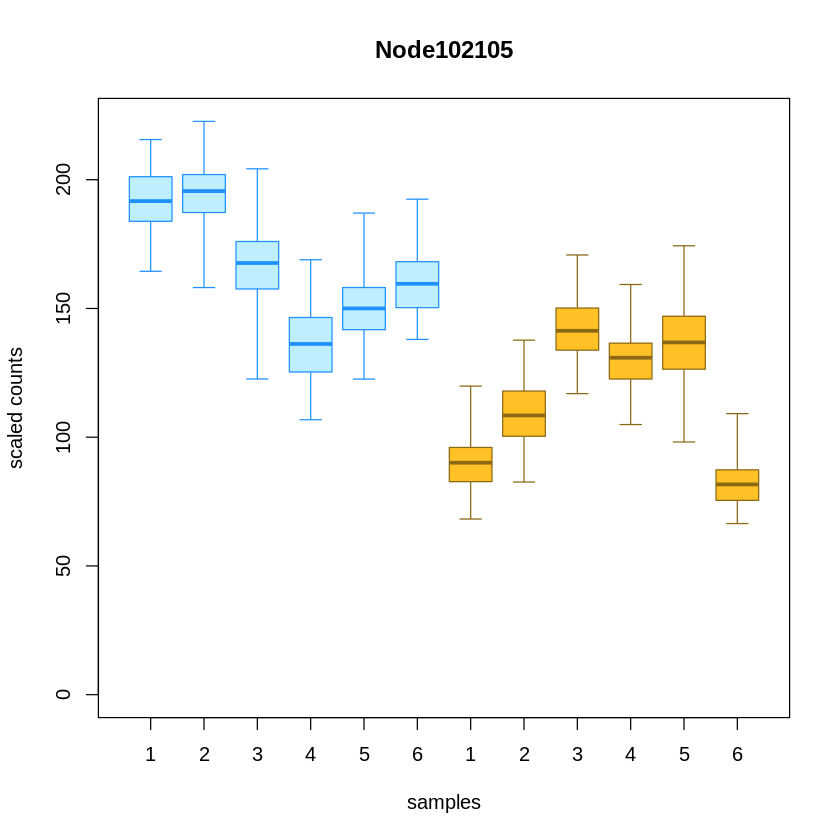

In [86]:
### What is causing this expression to fall
### tcr how to solve it
j <- c(5,9)
plotInfReps(y=yg, x = "condition", idx = genesTreeDE[[i]][[lfcNodes[j]]])
plotInfReps(y=yAll, x = "condition", idx = treeDE[[i]][lfcNodes[j]])
# plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[i]][lfcNodes[j]]))[1])
# plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[i]][lfcNodes[j]]))[2])
# plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[i]][lfcNodes[j]]))[3])

In [82]:
j <- 5
mcols(yg)[genesTreeDE[[i]][[lfcNodes[j]]],]
mcols(yAll)[treeDE[[i]][lfcNodes[[j]]],]

DataFrame with 1 row and 9 columns
                                    gene_id
                                <character>
ENSMUSG00000028651.12 ENSMUSG00000028651.12
                                                                                  tx_ids
                                                                         <CharacterList>
ENSMUSG00000028651.12 ENSMUST00000030404.4,ENSMUST00000136466.7,ENSMUST00000126558.7,...
                      log10mean      keep      stat    log2FC    pvalue
                      <numeric> <logical> <numeric> <numeric> <numeric>
ENSMUSG00000028651.12   2.42924      TRUE     -6.93 -0.118778  0.244934
                         locfdr    qvalue
                      <numeric> <numeric>
ENSMUSG00000028651.12         1  0.384265

DataFrame with 1 row and 5 columns
          meanInfRV log10mean      keep    log2FC    qvalue
          <numeric> <numeric> <logical> <numeric> <numeric>
Node99551  0.924971    2.0666      TRUE -0.725937 0.0339221

In [60]:
genesTreeDE[[i]][[lfcNodes[j]]]

[1] "ENSMUSG00000056708.5"

In [23]:
## A lowering of the LFC but also along with a substantial decrease in infRV
## Some of these nodes map to multiple genes some of which are DEs
head(order(mcols(yAll)[treeDE[[2]][lfcNodes],"log10mean"], decreasing=T), 30)
j <- 118
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
print(gs)
mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC")]
mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]
print("j")

j <- 25
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
mcols(yg)[gs,c("log10mean", "log2FC")]
mcols(yAll)[cbind(treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC")),]
mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]
print("j")
# j <- 142
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# mcols(yg)[gs,c("log10mean", "log2FC")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC")]
# mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]

# j <- 143
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]

[1] 118  25 142 143  65 188  50   5 158  61  21  69 135 222 194  98  48 213  64
[20] 147 113 208 105  31  67  19  91 125 156 116

[1] "ENSMUSG00000038717.8"


DataFrame with 1 row and 3 columns
                     log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric>
ENSMUSG00000038717.8   3.88265  0.200366  0.614476

DataFrame with 1 row and 3 columns
           meanInfRV log10mean    log2FC
           <numeric> <numeric> <numeric>
Node135025  0.878695   3.76715 -0.525694

DataFrame with 2 rows and 3 columns
                     meanInfRV log10mean    log2FC
                     <numeric> <numeric> <numeric>
ENSMUST00000213999.1   1.82022   3.59143 -0.571328
ENSMUST00000043675.8   4.11910   3.30611 -0.457364

[1] "j"


DataFrame with 1 row and 2 columns
                      log10mean    log2FC
                      <numeric> <numeric>
ENSMUSG00000022565.15    4.0153  -1.38563

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
"subscript is an array, passing it thru as.vector() first"


DataFrame with 6 rows and 5 columns
     meanInfRV log10mean      keep    log2FC    qvalue
     <numeric> <numeric> <logical> <numeric> <numeric>
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA

DataFrame with 3 rows and 3 columns
                      meanInfRV log10mean    log2FC
                      <numeric> <numeric> <numeric>
ENSMUST00000074834.11   258.479   3.09477  -1.42773
ENSMUST00000169108.7    324.507   3.17899  -1.25254
ENSMUST00000169438.7    361.319   2.66116  -1.04827

[1] "j"


#### Genes belonging to treeDE nodes that intersect with differentially expressed genes but are not covered by transcripts.'
We see many such genes that contain differential nodes but no differentially expressed transcripts. The magnitude of logFC in most cases though decreases from trancript to gene.

In [21]:
treeDECommonInds <- lapply(seq_along(genesTreeDE), function(i) {
    which(sapply(genesTreeDE[[i]], function(gs) sum(gs %in% diffGenes[[i]]) > 0))
})
sapply(treeDECommonInds,length)

[1] 309 428 465

In [22]:
save(treeDECommonInds, file="treeDE_Paper_Images/mousemuscle/treeDECommonInds.RData")

In [26]:
i <- 3
#121,263,269,292,301
for(j in c(73,308,317,335,356,47,95,244,262)) {
    g <- genesNodeCommonDGE[[i]][j]
    txps <- unlist(mcols(yg)[g,2])
    print(length(txps))
    print(mcols(yg)[g,c("log10mean", "log2FC", "qvalue")])
    print(mcols(y)[txps[which.min(abs(mcols(y)[txps, 'qvalue']))],c("log10mean", "log2FC", "qvalue")])
    print(mcols(yAll)[treeDE[[i]][treeDECommonInds[[i]][[j]]],c("meanInfRV", "log10mean", "log2FC", "qvalue")])
    print(mcols(y)[Descendants(treeCons,treeDE[[i]][treeDECommonInds[[i]][[j]]])[[1]],c("meanInfRV", "log10mean", "log2FC", "qvalue")])
}


[1] 5
DataFrame with 1 row and 3 columns
                      log10mean    log2FC      qvalue
                      <numeric> <numeric>   <numeric>
ENSMUSG00000070509.15   2.56105   -1.0168 1.08696e-05
DataFrame with 1 row and 3 columns
                      log10mean    log2FC    qvalue
                      <numeric> <numeric> <numeric>
ENSMUST00000094312.11   2.06927  -1.12426  0.105674
DataFrame with 1 row and 4 columns
           meanInfRV log10mean    log2FC      qvalue
           <numeric> <numeric> <numeric>   <numeric>
Node113356 0.0404829   2.52999  -1.02839 4.24828e-06
DataFrame with 3 rows and 4 columns
                      meanInfRV log10mean    log2FC    qvalue
                      <numeric> <numeric> <numeric> <numeric>
ENSMUST00000119206.2    26.8956   1.99132 -1.327839  0.165033
ENSMUST00000094312.11   31.3990   2.06927 -1.124258  0.105674
ENSMUST00000139780.2    28.1462   2.09908 -0.638777  0.713679
[1] 3
DataFrame with 1 row and 3 columns
                      log

https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000026883;r=2:35448278-35621006
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000057315;mr=5:102861682-103051275;r=5:102629257-103045803;t=ENSMUST00000073302
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000070509;r=7:73025257-73069647
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000019699;r=1:176847639-177085769
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000038481;r=10:40215560-40359814
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000022553;r=15:76235494-76238580
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000021143;r=12:112978128-113038021
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000038807;r=11:74274182-74501741

In [5]:
sum(mcols(y)[treeCons$tip,"qvalue"] < 0.01, na.rm=T)
sum(mcols(y)[treeCons$tip,"qvalue"] < 0.05, na.rm=T)
sum(mcols(y)[treeCons$tip,"qvalue"] < 0.1, na.rm=T)

sum(mcols(yAll)[treeCons$tip,"qvalue"] < 0.01, na.rm=T)
sum(mcols(yAll)[treeCons$tip,"qvalue"] < 0.05, na.rm=T)
sum(mcols(yAll)[treeCons$tip,"qvalue"] < 0.1, na.rm=T)

[1] 3384

[1] 6784

[1] 9641

[1] 869

[1] 5631

[1] 8348

#### Plot Transcripts from
https://nullranges.github.io/tidy-ranges-tutorial/isoform-analysis.html

In [102]:
library(org.Mm.eg.db)
library(TxDb.Mmusculus.UCSC.mm10.knownGene) ## this one corresponds to the version we need
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("ggplotify"))
suppressPackageStartupMessages(library("ggplot2"))

txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
txpMouse <- transcripts(txdb)


txpMouse <- txpMouse %>%
  mutate(tx_id = as.character(tx_id))

txpMouse <- txpMouse %>%
  mutate(gene_id = mapIds(
           txdb, keys=tx_id,
           column="GENEID", keytype="TXID")
         ) %>%
  filter(!is.na(gene_id))
head(txpMouse)
txpMouse <- txpMouse %>%
  mutate(ensID = mapIds(
           org.Mm.eg.db, keys=gene_id,
           column="ENSEMBL", keytype="ENTREZID")
         ) %>%
  filter(!is.na(ensID))
length(txpMouse)
txpMouse <- txpMouse %>%
                filter(tx_name %in% treeCons$tip)
head(txpMouse)
length(txpMouse)

'select()' returned 1:1 mapping between keys and columns



GRanges object with 6 ranges and 3 metadata columns:
      seqnames          ranges strand |       tx_id               tx_name
         <Rle>       <IRanges>  <Rle> | <character>           <character>
  [1]     chr1 4807788-4848410      + |          14  ENSMUST00000134384.7
  [2]     chr1 4807823-4846739      + |          15 ENSMUST00000027036.10
  [3]     chr1 4807830-4841286      + |          16  ENSMUST00000150971.7
  [4]     chr1 4807892-4886770      + |          17  ENSMUST00000155020.1
  [5]     chr1 4807896-4845174      + |          18  ENSMUST00000119612.8
  [6]     chr1 4807898-4840969      + |          19  ENSMUST00000137887.7
          gene_id
      <character>
  [1]       18777
  [2]       18777
  [3]       18777
  [4]       18777
  [5]       18777
  [6]       18777
  -------
  seqinfo: 66 sequences (1 circular) from mm10 genome

'select()' returned 1:many mapping between keys and columns



[1] 101405

GRanges object with 6 ranges and 4 metadata columns:
      seqnames          ranges strand |       tx_id               tx_name
         <Rle>       <IRanges>  <Rle> | <character>           <character>
  [1]     chr1 4807788-4848410      + |          14  ENSMUST00000134384.7
  [2]     chr1 4807823-4846739      + |          15 ENSMUST00000027036.10
  [3]     chr1 4807830-4841286      + |          16  ENSMUST00000150971.7
  [4]     chr1 4807892-4886770      + |          17  ENSMUST00000155020.1
  [5]     chr1 4807896-4845174      + |          18  ENSMUST00000119612.8
  [6]     chr1 4807898-4840969      + |          19  ENSMUST00000137887.7
          gene_id              ensID
      <character>        <character>
  [1]       18777 ENSMUSG00000025903
  [2]       18777 ENSMUSG00000025903
  [3]       18777 ENSMUSG00000025903
  [4]       18777 ENSMUSG00000025903
  [5]       18777 ENSMUSG00000025903
  [6]       18777 ENSMUSG00000025903
  -------
  seqinfo: 66 sequences (1 circular) from mm10 ge

[1] 84530

In [108]:
genesMouse <- genes(txdb)
genesMouse <- genesMouse %>%
  mutate(ensID = mapIds(org.Mm.eg.db, 
                            gene_id, "ENSEMBL", "ENTREZID")) %>% 
    filter(!is.na(ensID))
genesMouse

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

'select()' returned 1:many mapping between keys and columns



GRanges object with 24069 ranges and 2 metadata columns:
            seqnames              ranges strand |     gene_id
               <Rle>           <IRanges>  <Rle> | <character>
  100009600     chr9   21062393-21073096      - |   100009600
  100009609     chr7   84935565-84964115      - |   100009609
  100009614    chr10   77711457-77712009      + |   100009614
     100012     chr4 144157557-144162663      - |      100012
     100017     chr4 134741554-134768024      - |      100017
        ...      ...                 ...    ... .         ...
      99889     chr3   84496093-85887516      - |       99889
      99890     chr3 110246109-110250998      - |       99890
      99899     chr3 151730922-151749960      - |       99899
      99929     chr3   65528410-65555518      + |       99929
      99982     chr4 136550540-136602723      - |       99982
                         ensID
                   <character>
  100009600 ENSMUSG00000079681
  100009609 ENSMUSG00000066372
  100009614 E

In [109]:
txp_data <- txpMouse %>%
  select(tx_id, ensID, ntxp, .drop_ranges=TRUE) %>%
  as_tibble()
ids <- dplyr::left_join(tibble(tx_id = exons$tx_id),
                        txp_data, by="tx_id")
# ids
all.equal(exons$tx_id, ids$tx_id)
mcols(exons) <- cbind(mcols(exons), ids %>% select(-tx_id))


exon_parts <- exons %>%
  group_by(ensID)

[1] TRUE

In [116]:
i <- 1
order(abs(mcols(yAll)[treeDECommonInds[[i]], "log2FC"]), decreasing = TRUE)

[1]   9 158 169 151  47 303  17  91  22 288 180 285 246 116  23 162  87 178
 [19] 174 233 228  85  71 156  49 211 105 167 129 234 132 148   8 283 221 306
 [37] 232  57 299 257 213 135 173 252 123 154 122   2 265 147 131  99 222 260
 [55] 134 294   6  62 113 214  10  67 145  12 146 177 138 253 235 163 124  81
 [73] 275 241 125 208 166 200 111 108 256 280  11 229  54 127 204 172 190 227
 [91] 187  73  72 207  77 230  42 184 137 106  68 191  13 136 143  82 107 201
[109] 272 300 298  51 110 296 198  63  66  95  70  69  76  74 149  29  46  14
[127]   1 244  35  41 128 279  45 152 291 140 304 141 293   4 301  50 249 193
[145] 160  52  19  53 185  80  37 212 139 165 133 210  25 170 258 286  75 263
[163]  60 100  24 206  61  90 224  34 277  96 175 117 226 153 309 223 114  21
[181] 254 102 281 245  89 196 284  79  31  36  93 120 218  83  16 215 176 171
[199] 150 112  38 297   3 270 121 276 295 188 250 274 142 273 157  39  28 144
[217] 290  32  97  94 243  26 240 101 195 264 194 186 209 251  30  55 225  86
[235] 115  64 130 217 103  33 179 159 189 266 261 282  88 202 164 119  56  43
[253] 197 168  78 289 183 118  92 292  15  44 231 287 242 305 126 269  20  84
[271]  40 205 259 255 307 268 237 247 203 236 220 182   7 216 109 161  27 278
[289]   5 104  65 181 199  59 267 302 238 239  98  48 271  58 219 192 308 155
[307] 248  18 262

In [110]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 9
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)

length(gTxps)
gs[1]
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g


txp_min <- gTxps[which.min(mcols(y)[gTxps, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000040729.8" "ENSMUST00000160961.7" "ENSMUST00000233633.1"
[4] "ENSMUST00000162862.2"

[1] TRUE

[1] TRUE

[1] TRUE

[1] 7

[1] "ENSMUSG00000036636.10"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr17,25133391,25162104,28714,+,26373,ENSMUSG00000036636


[1] 2

[1] TRUE

In [62]:
options(repr.plot.width=14, repr.plot.height=9)
of=20.5
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.1) +
    geom_point2(aes(subset=(node==4), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==2), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = 4, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = 2, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

gg[gg2]

text[text2]

gg[gg3]



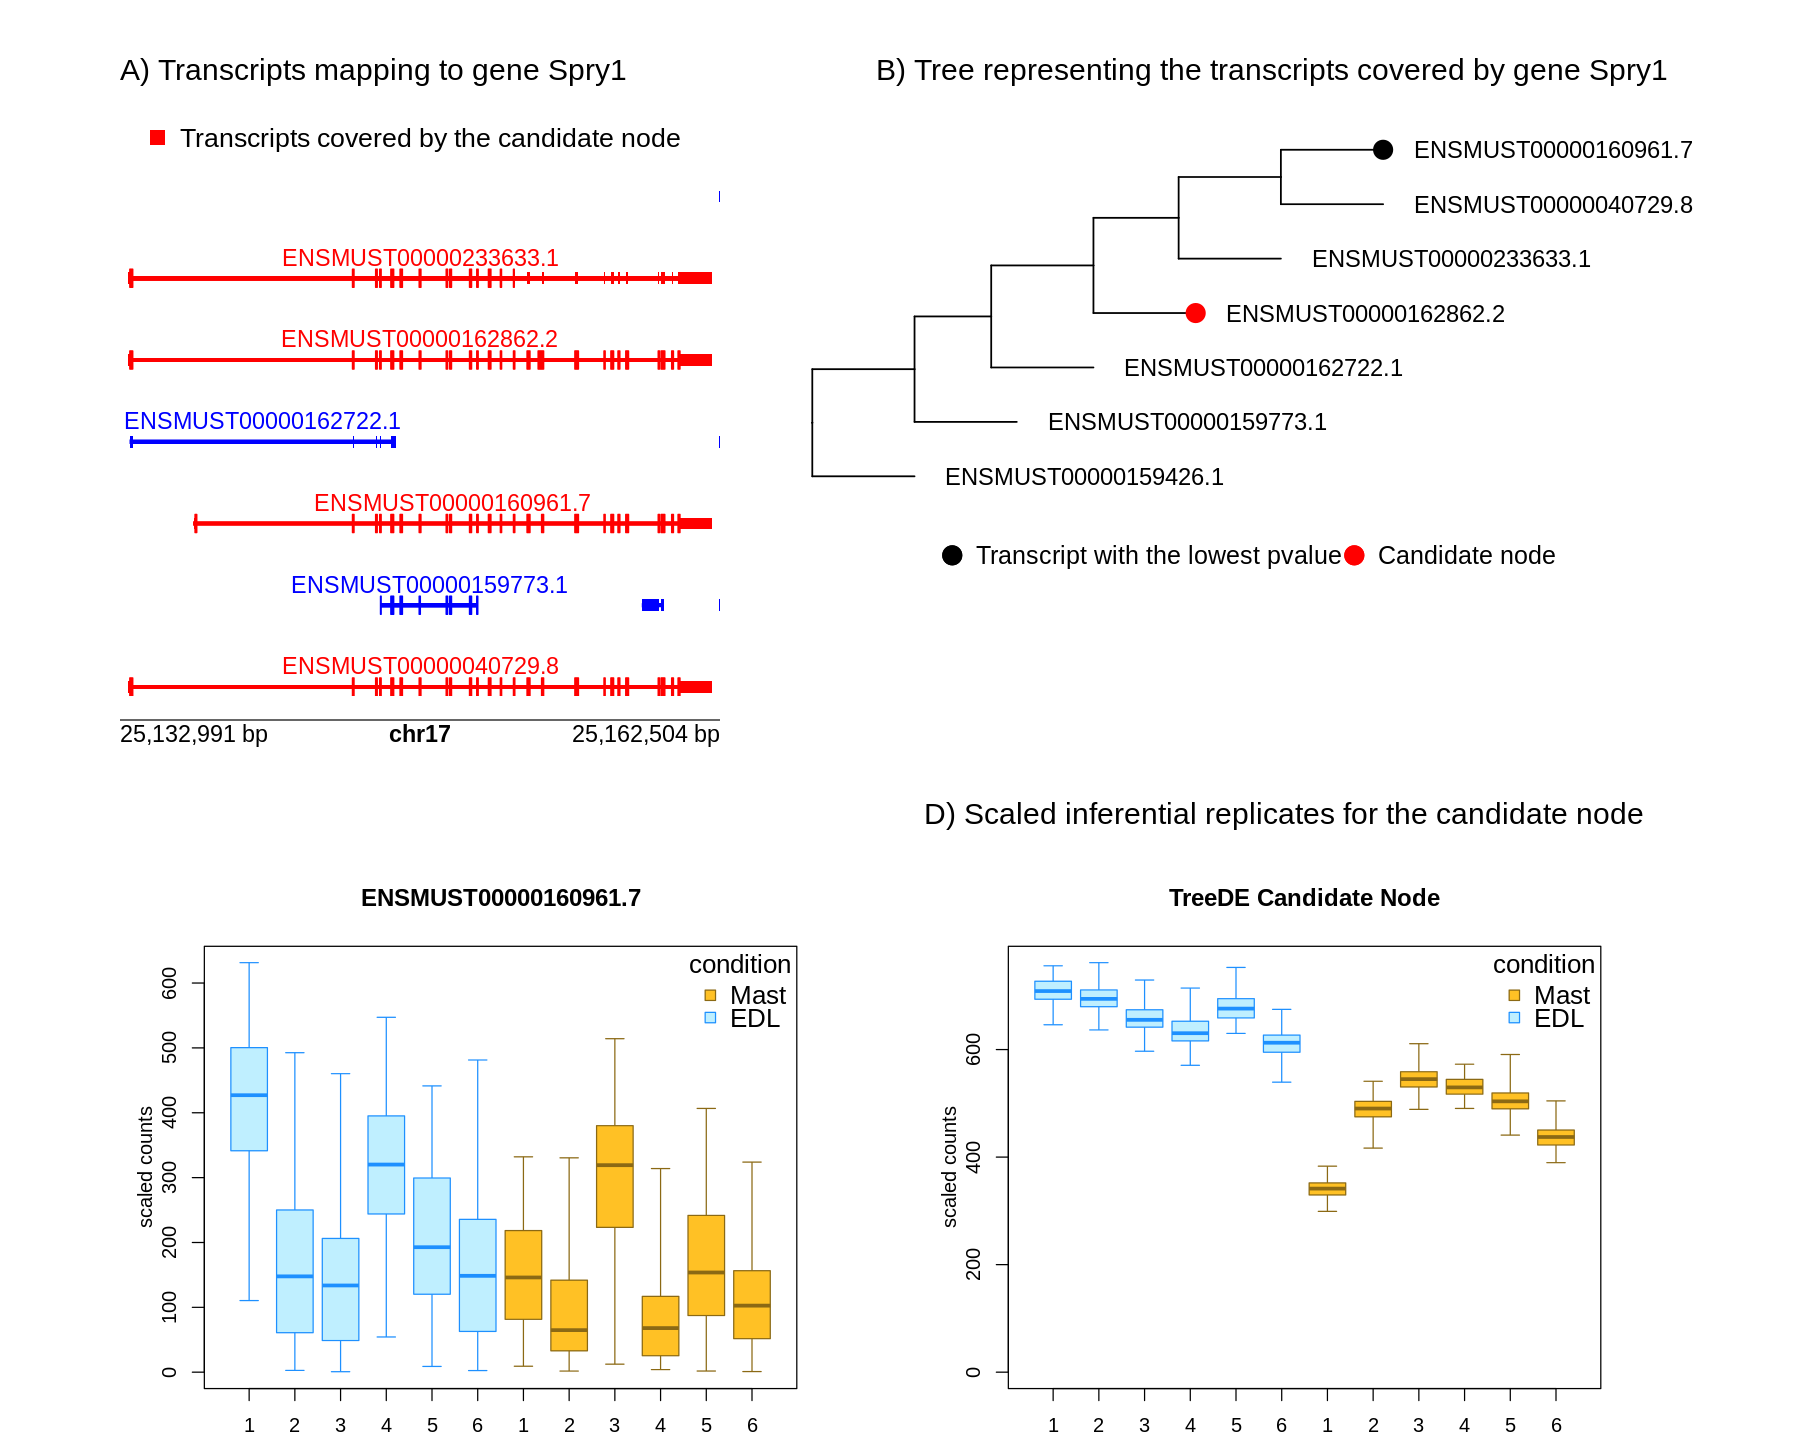

In [113]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 14, height = 11.4, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-400, chromend = g[["end"]]+400,
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

# hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
#                      color=c(rep("red", length(tx_to_show)), 
#                              rep("black", length(setdiff(treeSub$tip, tx_to_show)))))

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node"),
    fill = c("red"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene Spry1", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 5.5, width = 5, height = 6, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5.7, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Spry1", 
         x = 6.8, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 5.8, y = 0.6, width = 8, height=4
)

# plotText(label=paste("C) Scaled inferential replicates for the transcript", txp_min, sep="\n"), 
#          x = 0.5, y = 6.4, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 7, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 6.4, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 7, width = 6, height=5
)


In [103]:
txpMouse %>% filter(ensID=="ENSMUSG00000036636")

GRanges object with 7 ranges and 4 metadata columns:
      seqnames            ranges strand |       tx_id              tx_name
         <Rle>         <IRanges>  <Rle> | <character>          <character>
  [1]    chr17 25133391-25162099      + |      120790 ENSMUST00000162862.2
  [2]    chr17 25133391-25162104      + |      120791 ENSMUST00000040729.8
  [3]    chr17 25133391-25162104      + |      120792 ENSMUST00000233633.1
  [4]    chr17 25133465-25146543      + |      120793 ENSMUST00000162722.1
  [5]    chr17 25136622-25162098      + |      120794 ENSMUST00000160961.7
  [6]    chr17 25145809-25150586      + |      120795 ENSMUST00000159773.1
  [7]    chr17 25158655-25159742      + |      120796 ENSMUST00000159426.1
          gene_id              ensID
      <character>        <character>
  [1]       26373 ENSMUSG00000036636
  [2]       26373 ENSMUSG00000036636
  [3]       26373 ENSMUSG00000036636
  [4]       26373 ENSMUSG00000036636
  [5]       26373 ENSMUSG00000036636
  [6]       2

In [119]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 169
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)

gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])
gTxps

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
sum(gTxps %in% treeCons$tip)

gs[1]
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

txp_min <- gTxps[which.min(mcols(y)[gTxps, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000115072.7"  "ENSMUST00000069619.13" "ENSMUST00000115073.8"

[1] TRUE

ENSMUSG00000025862.14   ENSMUSG00000025862.14   ENSMUSG00000025862.14 
 "ENSMUST00000115073.8"  "ENSMUST00000115072.7"  "ENSMUST00000136323.7" 
  ENSMUSG00000025862.14   ENSMUSG00000025862.14   ENSMUSG00000025862.14 
 "ENSMUST00000127618.7"  "ENSMUST00000141414.1" "ENSMUST00000069619.13" 
  ENSMUSG00000025862.14   ENSMUSG00000025862.14 
 "ENSMUST00000123245.7"  "ENSMUST00000128799.2"

[1] TRUE

[1] TRUE

[1] 8

[1] "ENSMUSG00000025862.14"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chrX,42149317,42277185,127869,+,20843,ENSMUSG00000025862


[1] 2

[1] TRUE

In [122]:
options(repr.plot.width=14, repr.plot.height=9)
of=58.5
inNode <- 14
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 160) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



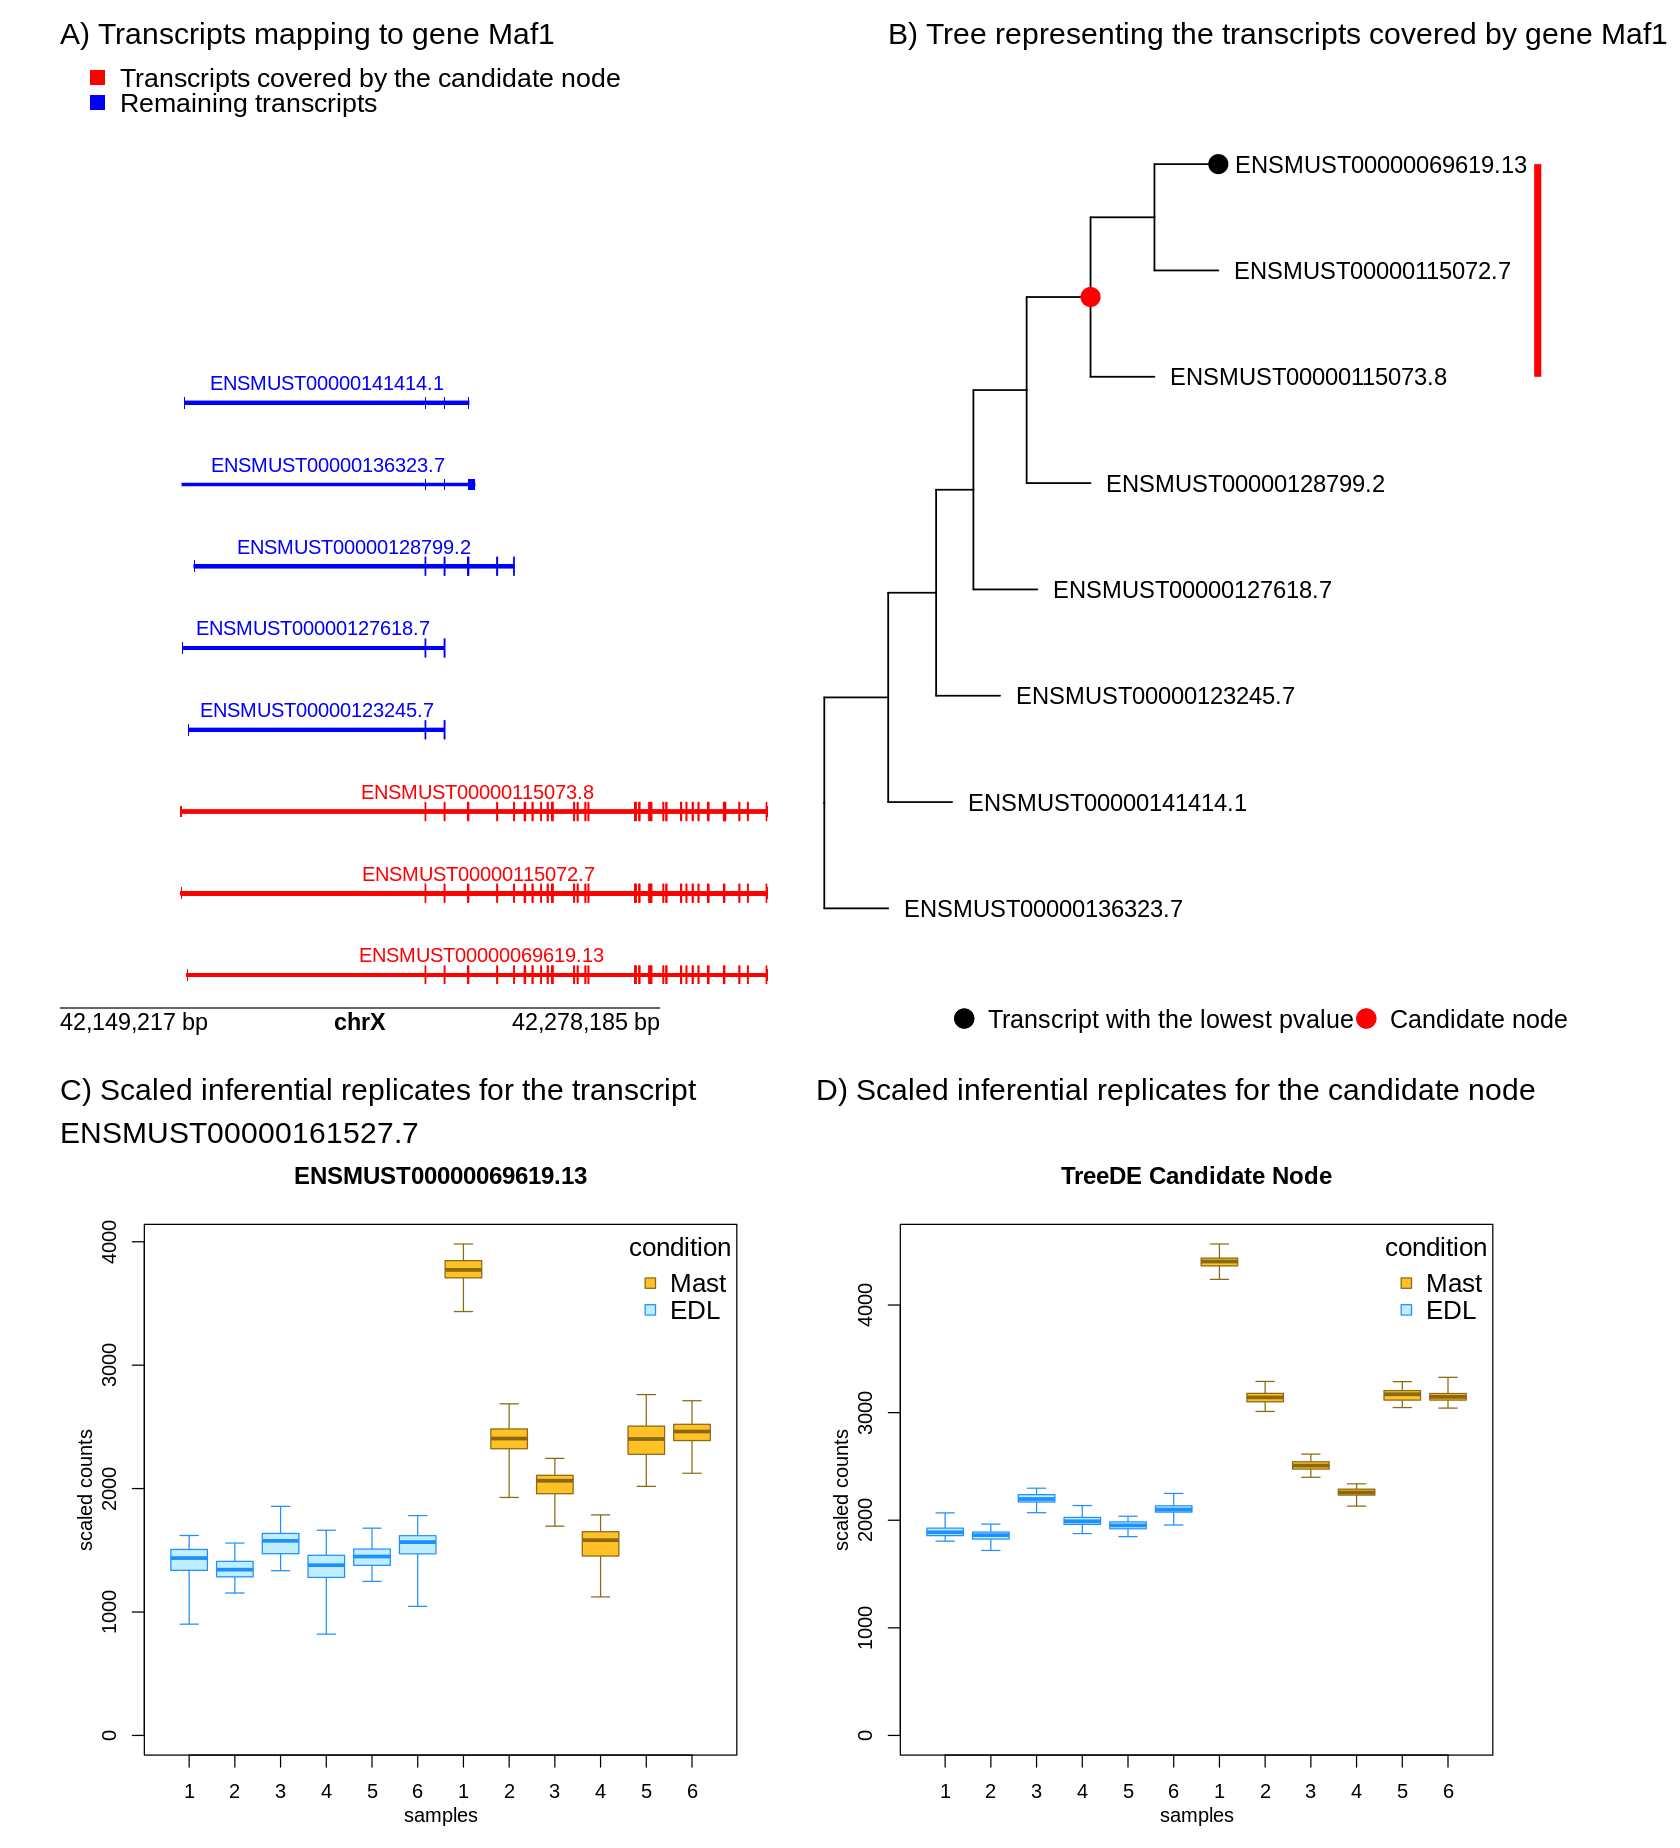

In [123]:
options(repr.plot.width=14, repr.plot.height=15.4)
library(plotgardener)
pageCreate(width = 14, height = 15.4, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-100, chromend = g[["end"]]+1000,
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=12
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.5, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Maf1", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 1.5, y = 8.2, width = 5, height = 8.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 8.4, length=5,
  just = c("left", "top"), fontsize=14
)

plotText(label="B) Tree representing the transcripts covered by gene Maf1", 
         x = 7.4, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.4, y =0.76, width = 8, height=8
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000161527.7", 
         x = 0.5, y = 9, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 9.5, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 6.8, y = 9, params = parText)

plotGG(
    plot = pInn,
    x = 6.8, y = 9.5, width = 6, height=6
)


In [126]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 47
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)
length(treeSub$tip)

gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- gTxps[which.min(mcols(y)[gTxps, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000025767.13" "ENSMUST00000117831.7"  "ENSMUST00000121402.1"

[1] 6

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000024847.15"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr19,4114446,4125858,11413,-,11632,ENSMUSG00000024847


ENSMUSG00000024847.15   ENSMUSG00000024847.15   ENSMUSG00000024847.15 
 "ENSMUST00000117831.7" "ENSMUST00000025767.13"  "ENSMUST00000121402.1" 
  ENSMUSG00000024847.15   ENSMUSG00000024847.15   ENSMUSG00000024847.15 
 "ENSMUST00000236509.1"  "ENSMUST00000127767.1"  "ENSMUST00000136043.1"

[1] 1

[1] TRUE

In [129]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 10
lNode <- match(txp_min, treeSub$tip)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

Warning message:
"Not enough plotting space for all provided elements. ('+' indicates elements not shown.)"
transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



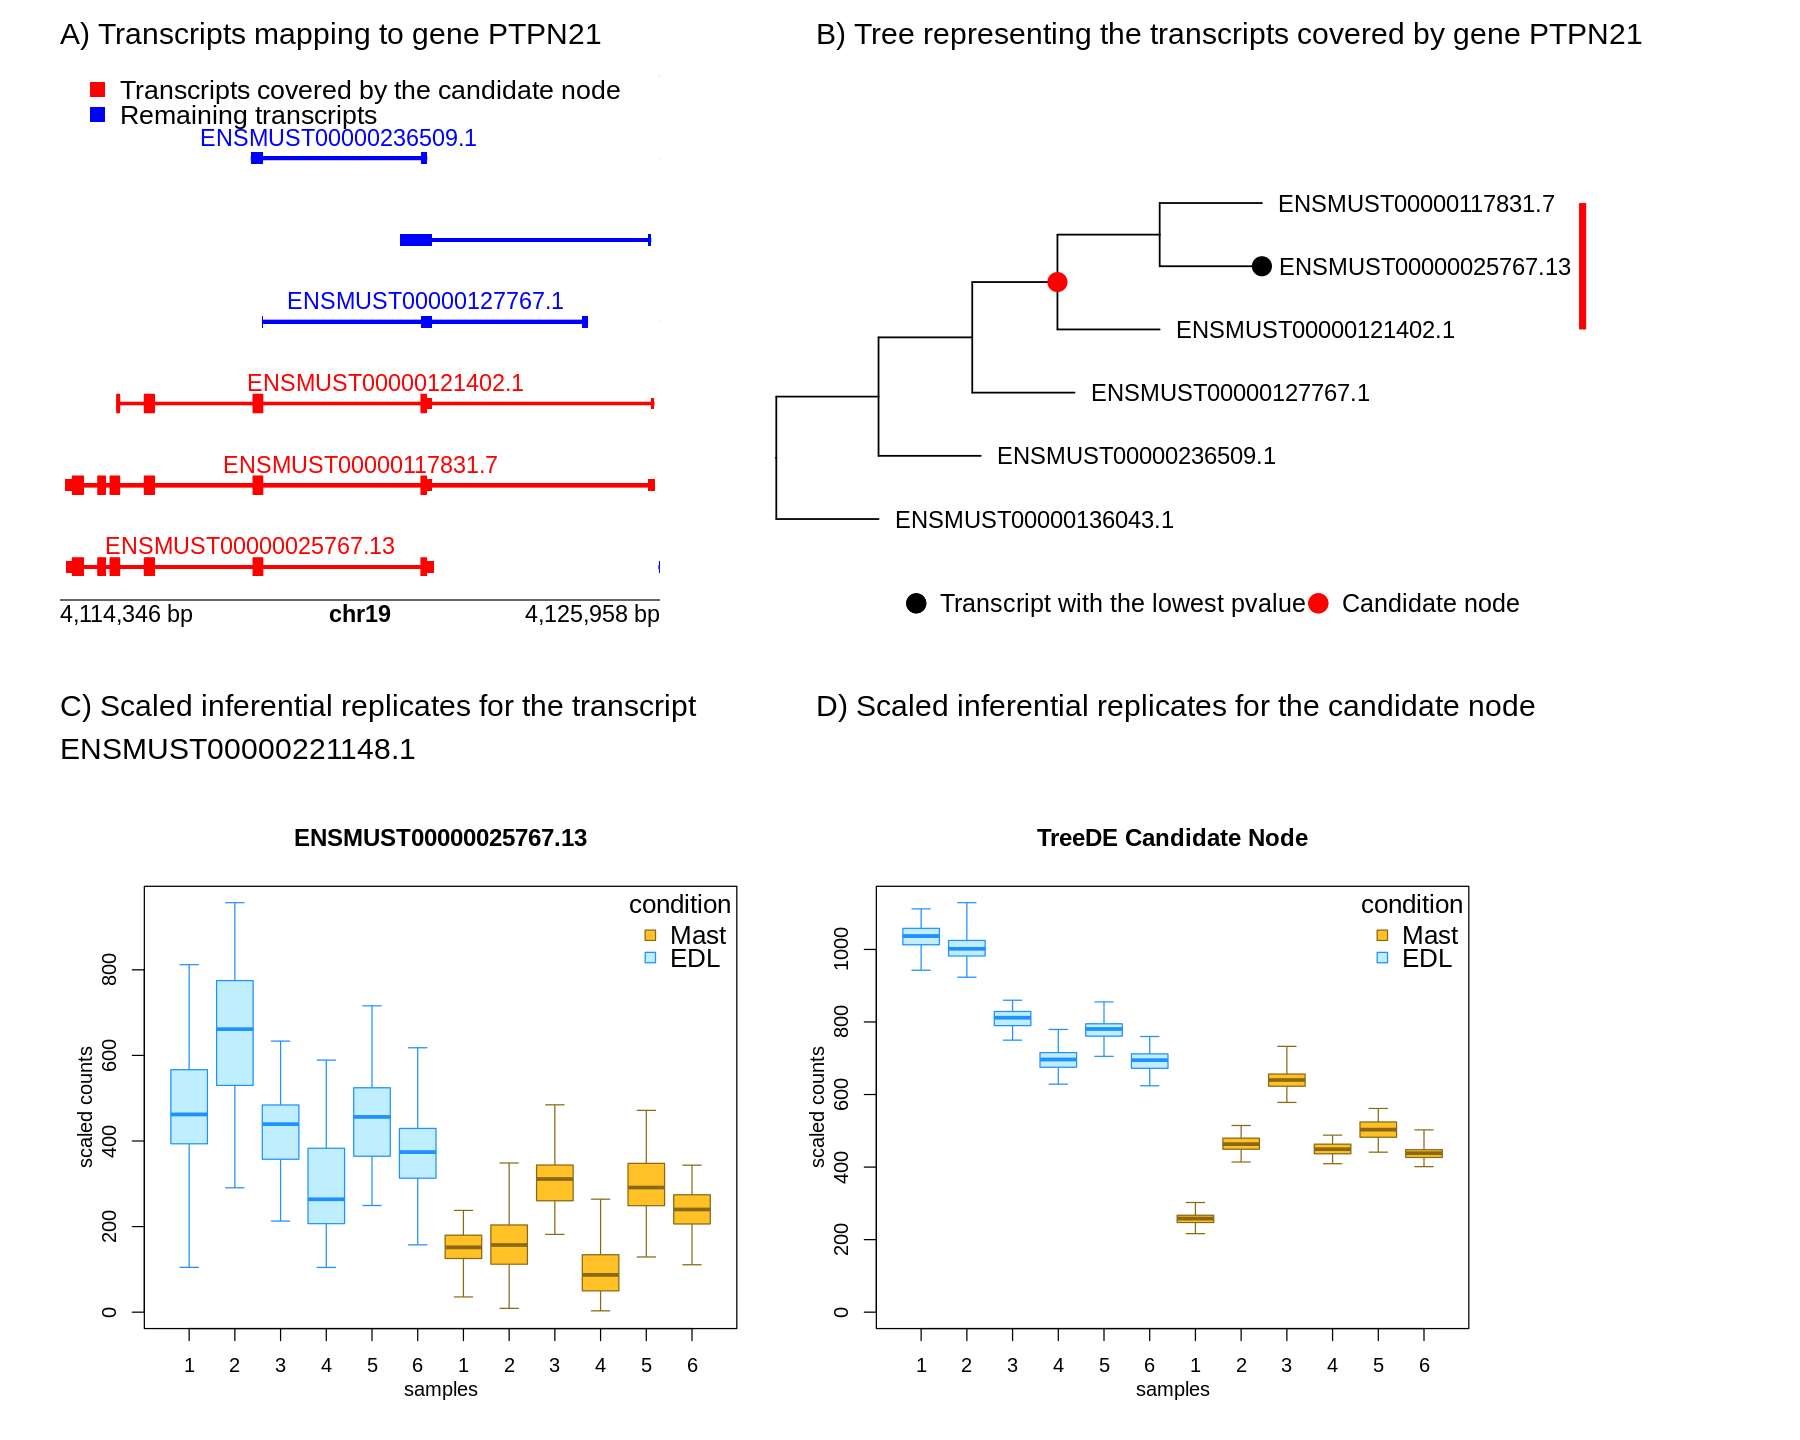

In [131]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-100, chromend = g[["end"]]+100,
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene PTPN21", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.8, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene PTPN21", 
         x = 6.8, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000221148.1", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 6.8, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 6.6, y = 6.8, width = 6, height=5
)


In [61]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 451
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- gTxps[which.min(mcols(y)[gTxps, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000118810.1" "ENSMUST00000075667.4" "ENSMUST00000119664.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000041775.7"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr7,138835823,138846273,10451,-,69546,ENSMUSG00000041775


ENSMUSG00000041775.7   ENSMUSG00000041775.7   ENSMUSG00000041775.7 
"ENSMUST00000119664.1" "ENSMUST00000075667.4" "ENSMUST00000118810.1"

[1] 2

[1] TRUE

In [62]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 4
lNode <- 2
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



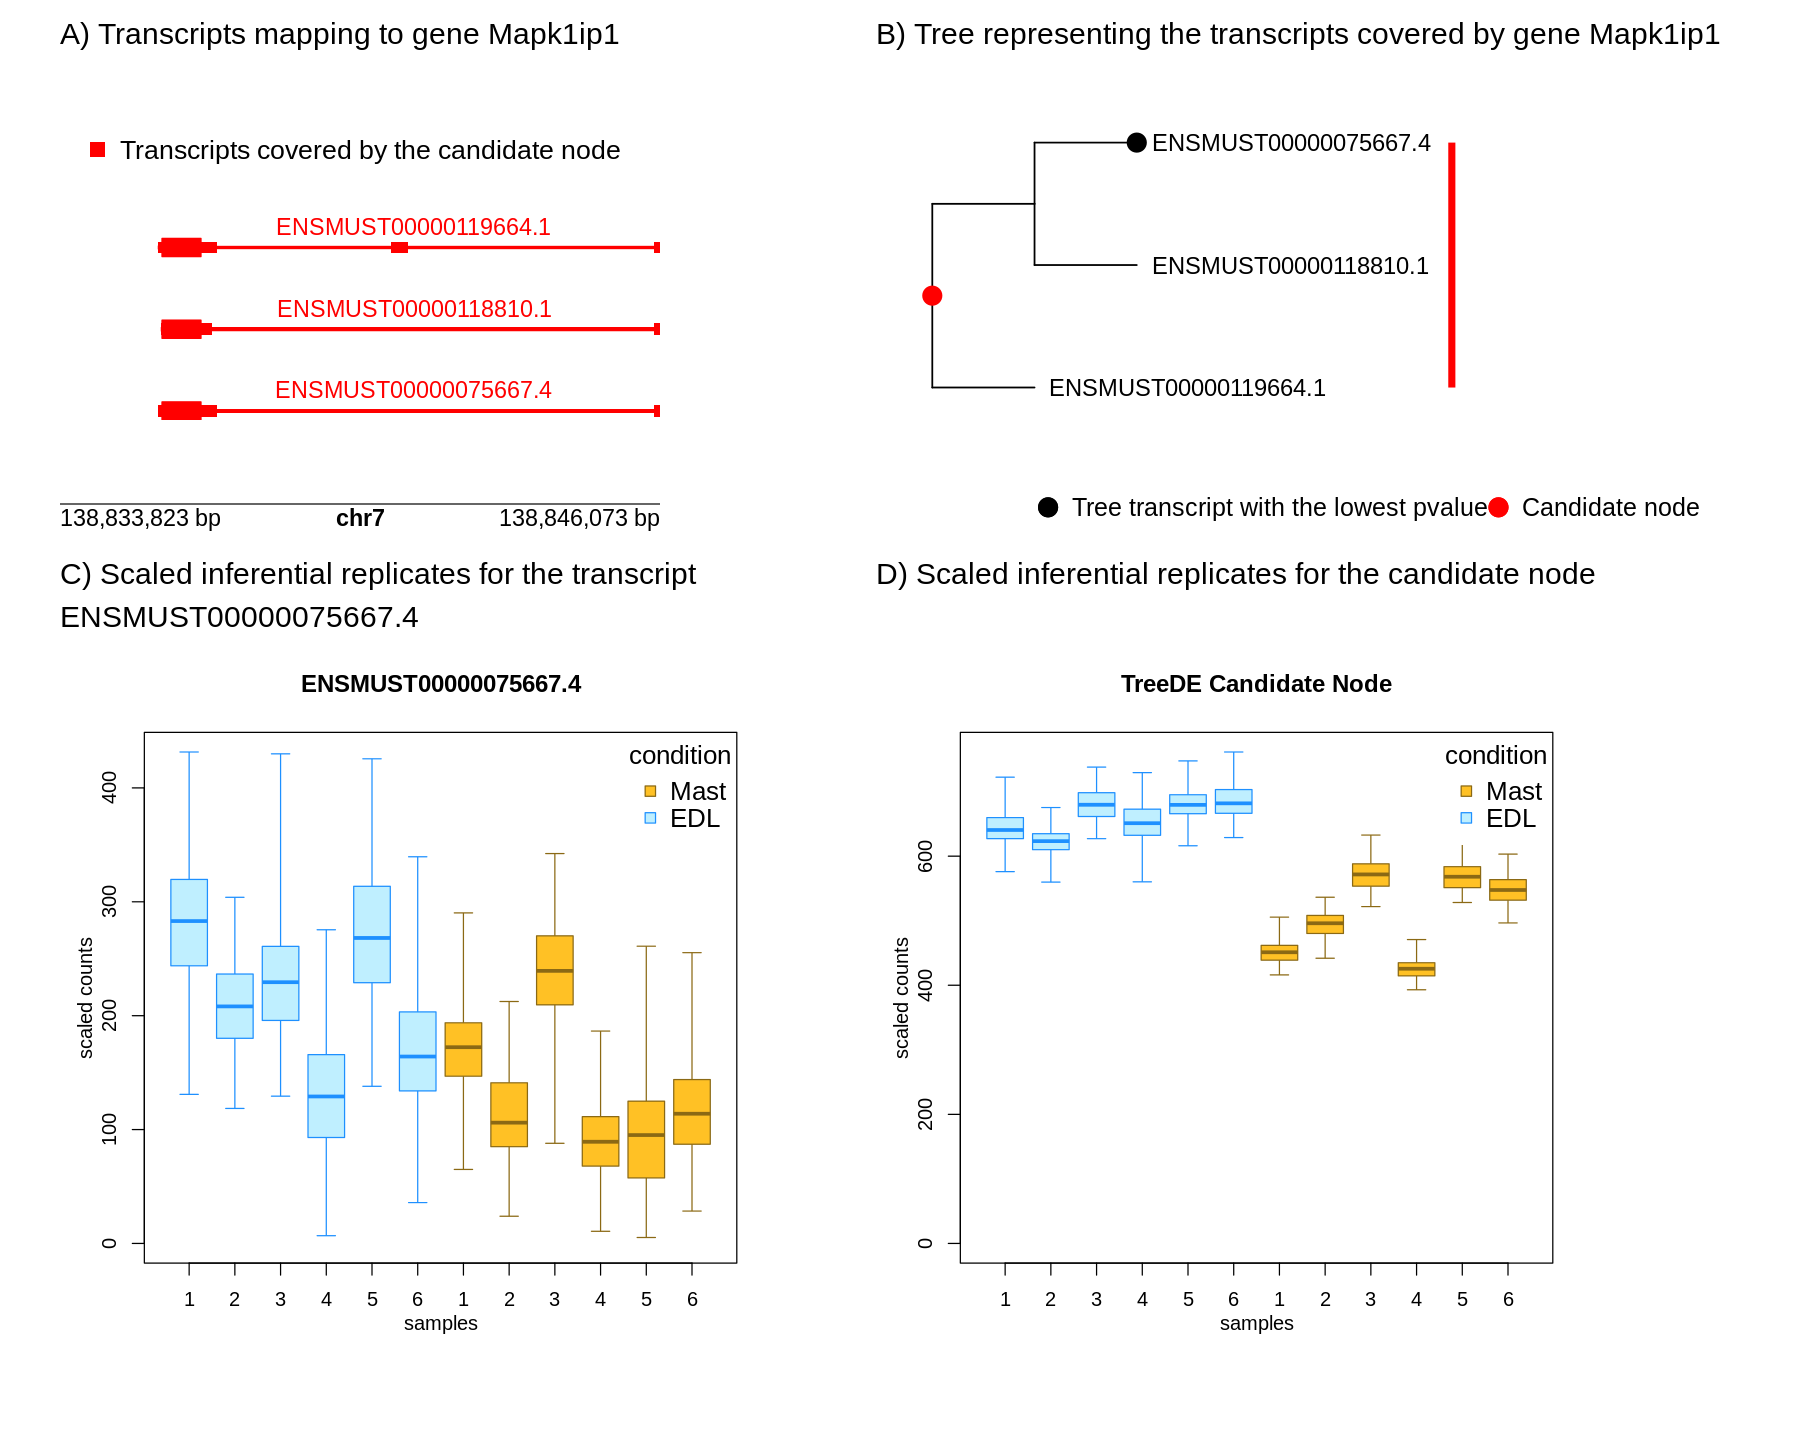

In [79]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]]-200,
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node"),
    fill = c("red"), border = FALSE,
    x = 0.5, y = 1, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene Mapk1ip1", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 3.5, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.2, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Mapk1ip1", 
         x = 7.3, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 7.3, y = 0.5, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000075667.4", 
         x = 0.5, y = 4.7, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 5.4, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.3, y = 4.7, params = parText)

plotGG(
    plot = pInn,
    x = 7.3, y = 5.4, width = 6, height=6
)


In [58]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 49
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000093360.11" "ENSMUST00000166592.1"  "ENSMUST00000210576.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000031691.14"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr8,85036915,85057583,20669,+,212999,ENSMUSG00000031691


ENSMUSG00000031691.14   ENSMUSG00000031691.14   ENSMUSG00000031691.14 
"ENSMUST00000093360.11"  "ENSMUST00000211601.1"  "ENSMUST00000166592.1" 
  ENSMUSG00000031691.14   ENSMUSG00000031691.14   ENSMUSG00000031691.14 
 "ENSMUST00000210945.1"  "ENSMUST00000210576.1"  "ENSMUST00000210117.1" 
  ENSMUSG00000031691.14 
 "ENSMUST00000210461.1"

[1] 2

[1] TRUE

In [59]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 12
lNode <- 2
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



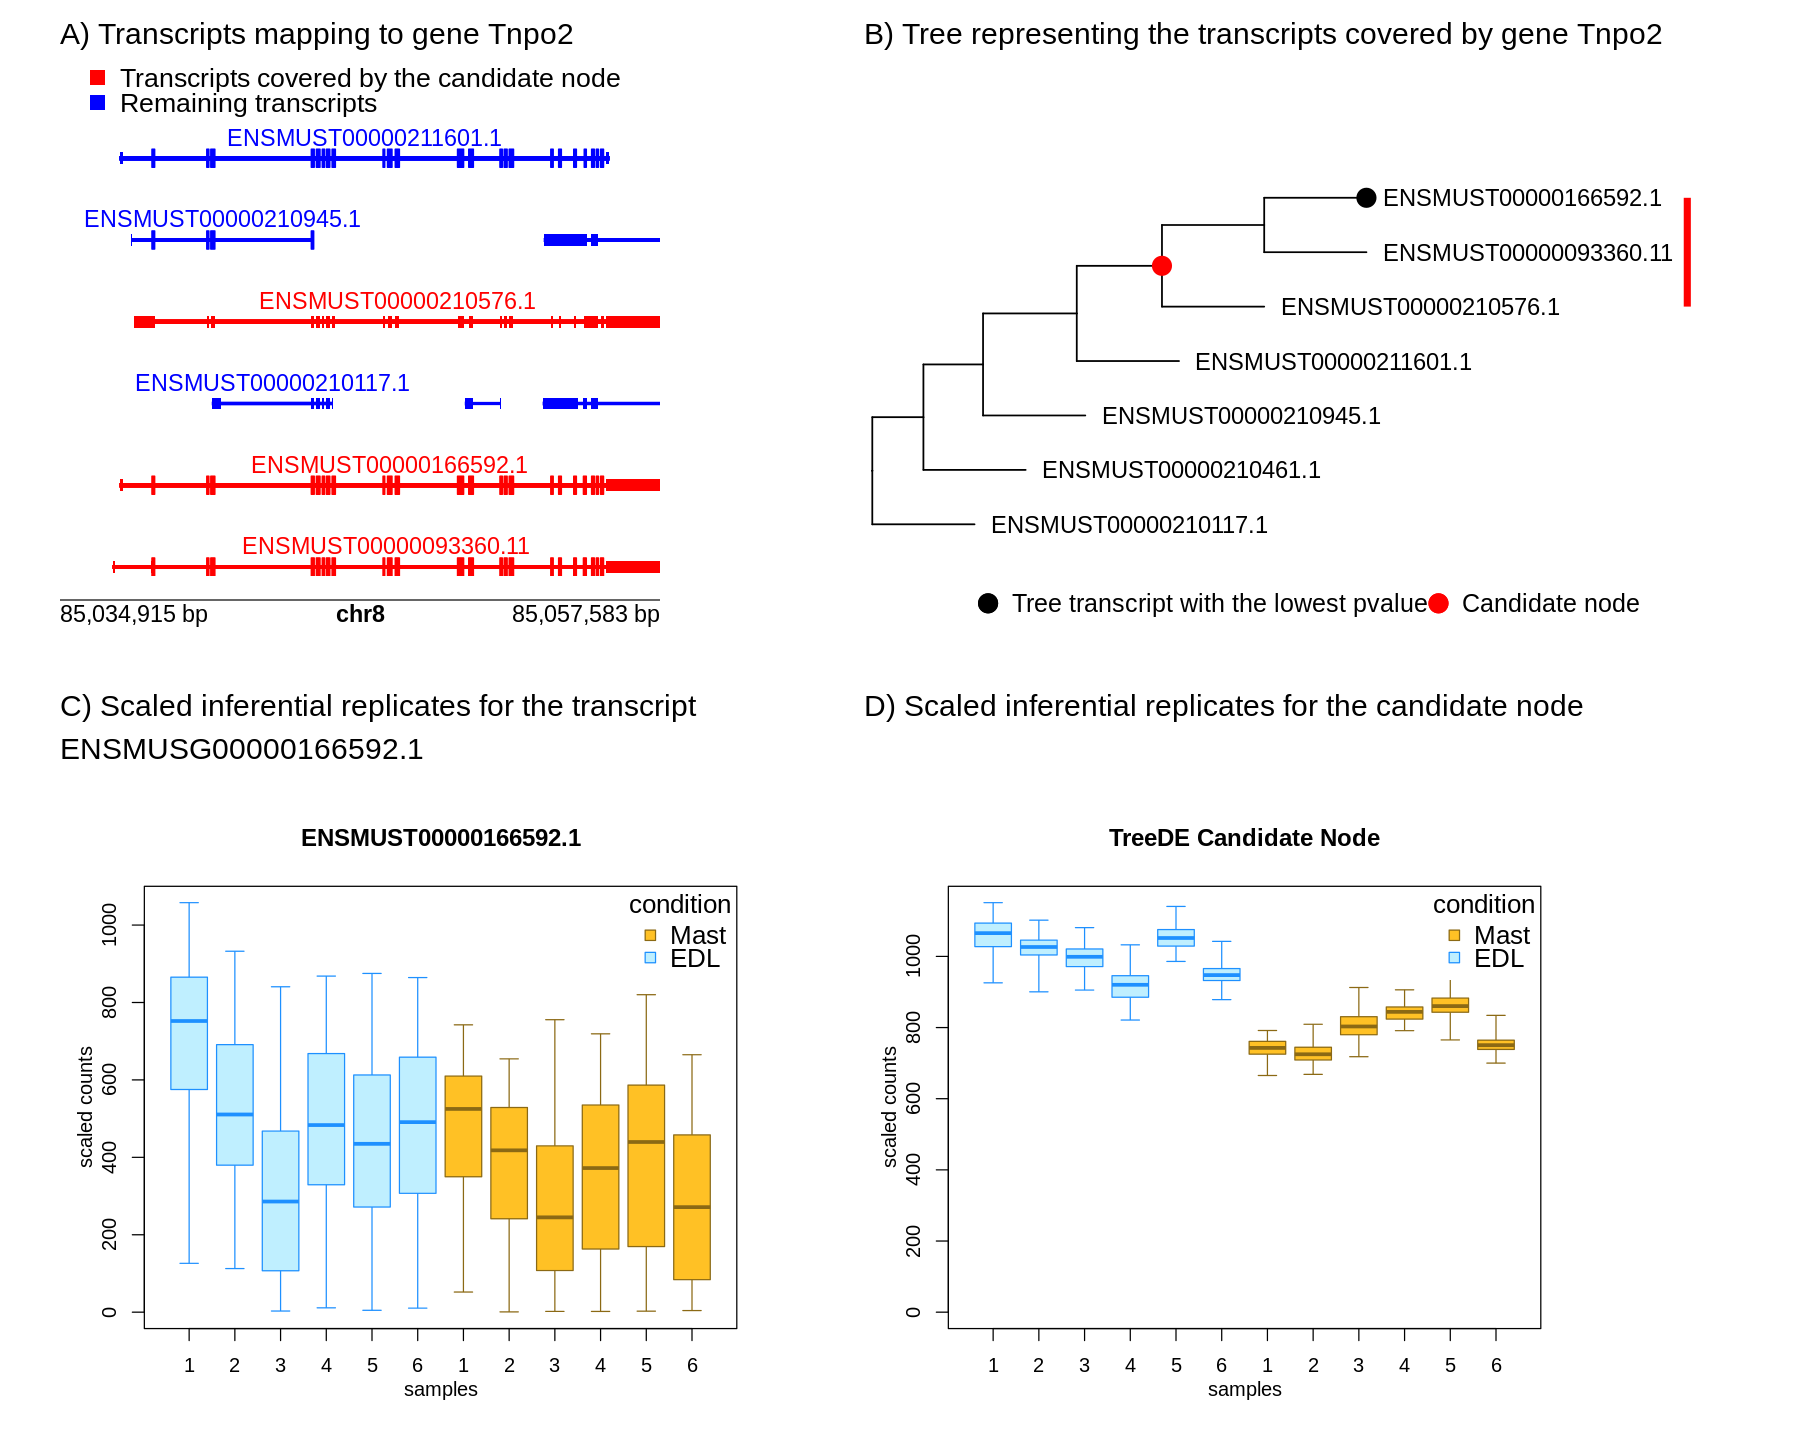

In [60]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.5, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene Tnpo2", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.8, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Tnpo2", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUSG00000166592.1", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [50]:
options(repr.plot.width=14, repr.plot.height=9)

j <- 312
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000114516.7" "ENSMUST00000121869.7" "ENSMUST00000147358.7"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000064061.13"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr16,48924232,48994165,69934,-,224170,ENSMUSG00000064061


ENSMUSG00000064061.13  ENSMUSG00000064061.13  ENSMUSG00000064061.13 
"ENSMUST00000147358.7" "ENSMUST00000121869.7" "ENSMUST00000139350.7" 
 ENSMUSG00000064061.13  ENSMUSG00000064061.13  ENSMUSG00000064061.13 
"ENSMUST00000114516.7" "ENSMUST00000151950.1" "ENSMUST00000123961.1" 
 ENSMUSG00000064061.13 
"ENSMUST00000133377.1"

[1] 1

[1] TRUE

In [51]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 11
lNode <- 1
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



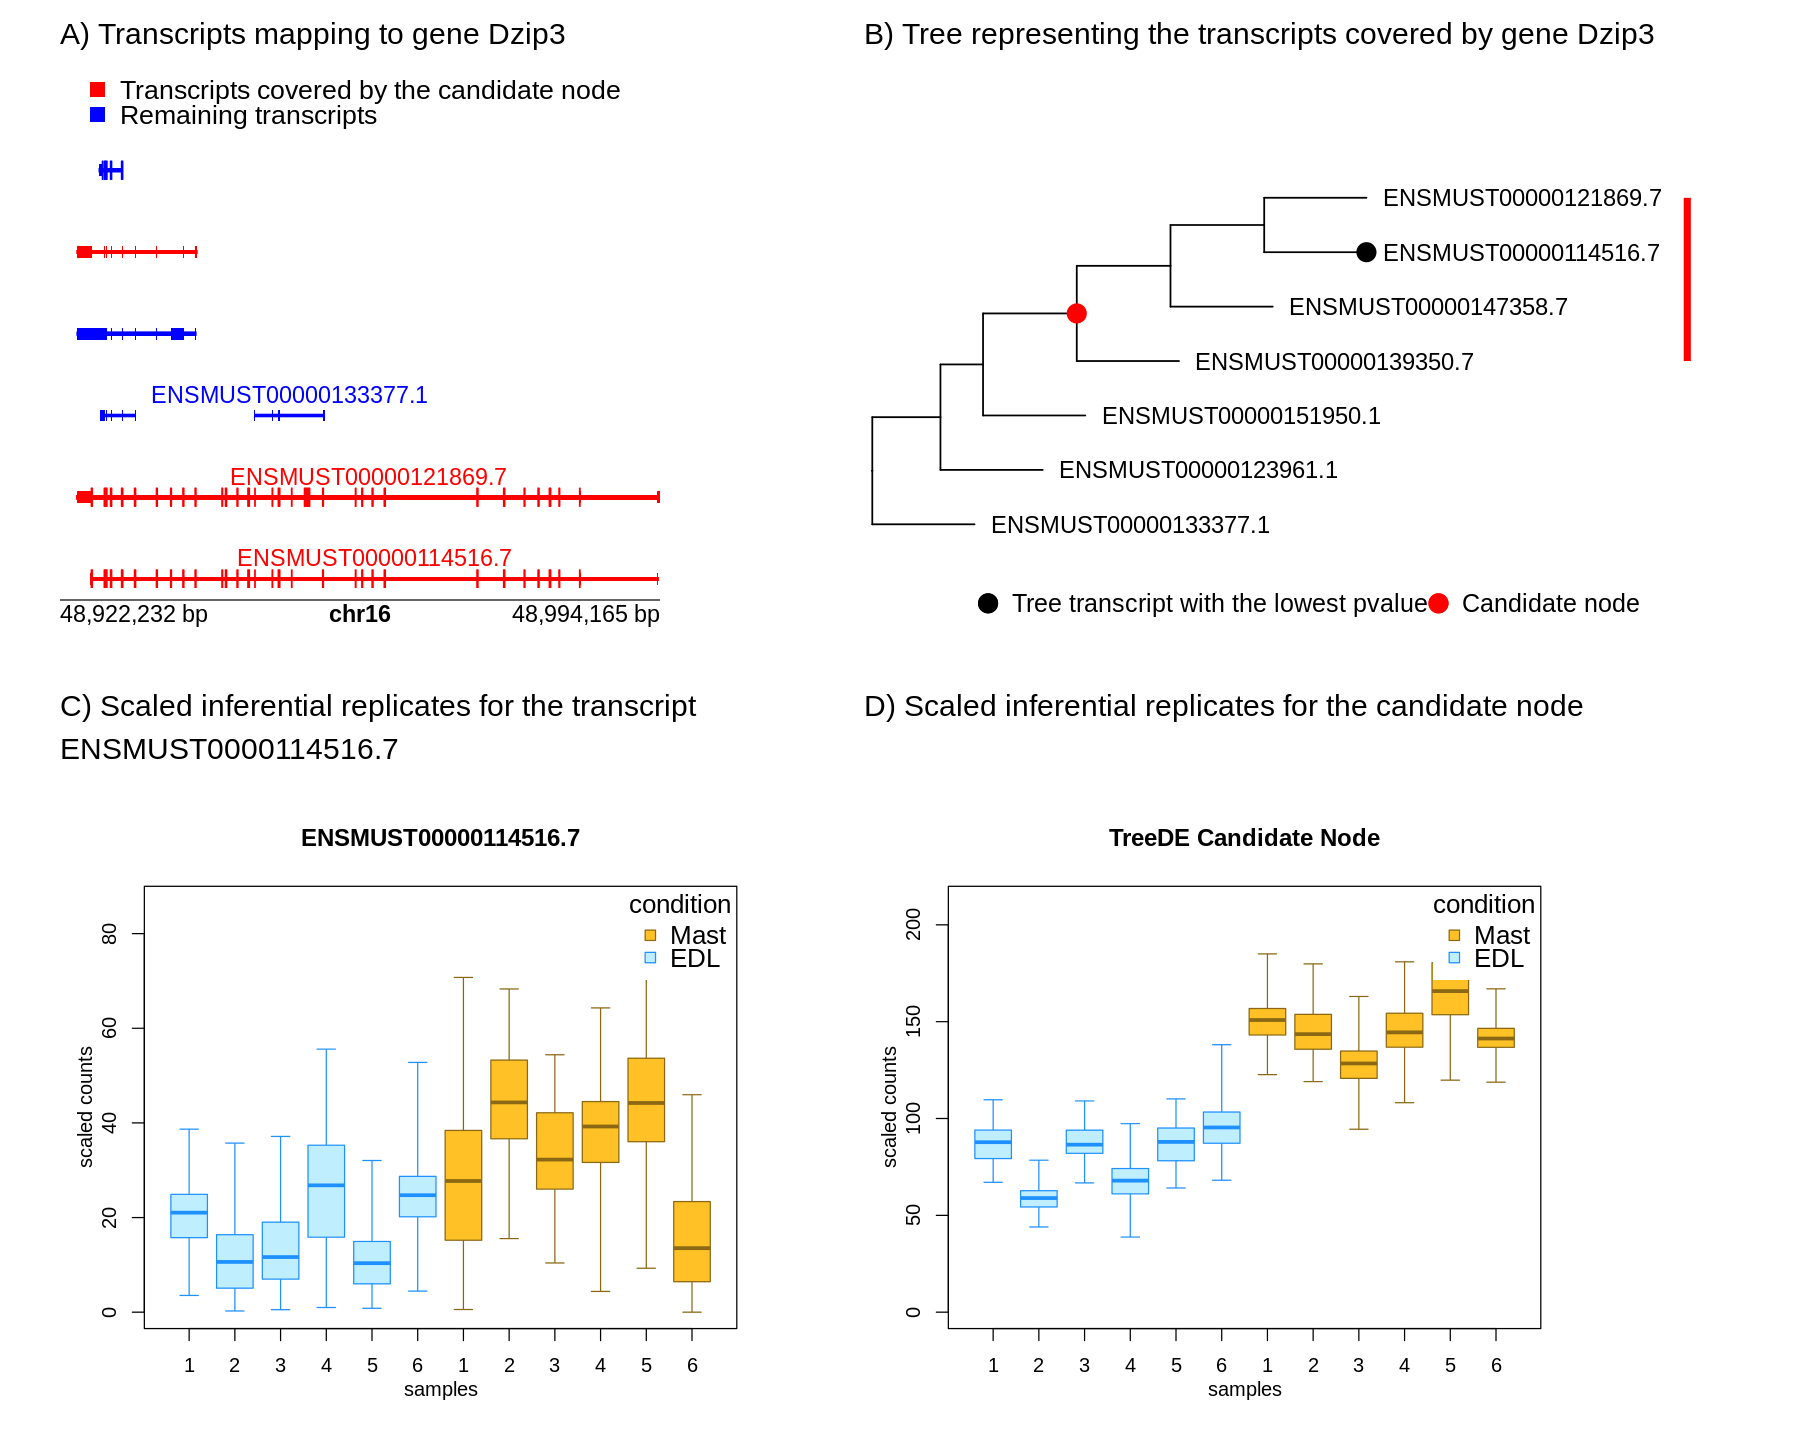

In [54]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)

plotText(label="A) Transcripts mapping to gene Dzip3", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.9, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Dzip3", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000114516.7", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [48]:
j <- 150
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000025826.6" "ENSMUST00000237371.1" "ENSMUST00000236152.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000024891.6"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr19,5023860,5031972,8113,+,13340,ENSMUSG00000024891


ENSMUSG00000024891.6   ENSMUSG00000024891.6   ENSMUSG00000024891.6 
"ENSMUST00000236152.1" "ENSMUST00000025826.6" "ENSMUST00000237371.1" 
  ENSMUSG00000024891.6   ENSMUSG00000024891.6   ENSMUSG00000024891.6 
"ENSMUST00000235416.1" "ENSMUST00000235933.1" "ENSMUST00000237267.1"

[1] 2

[1] TRUE

In [49]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 10
lNode <- 2
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



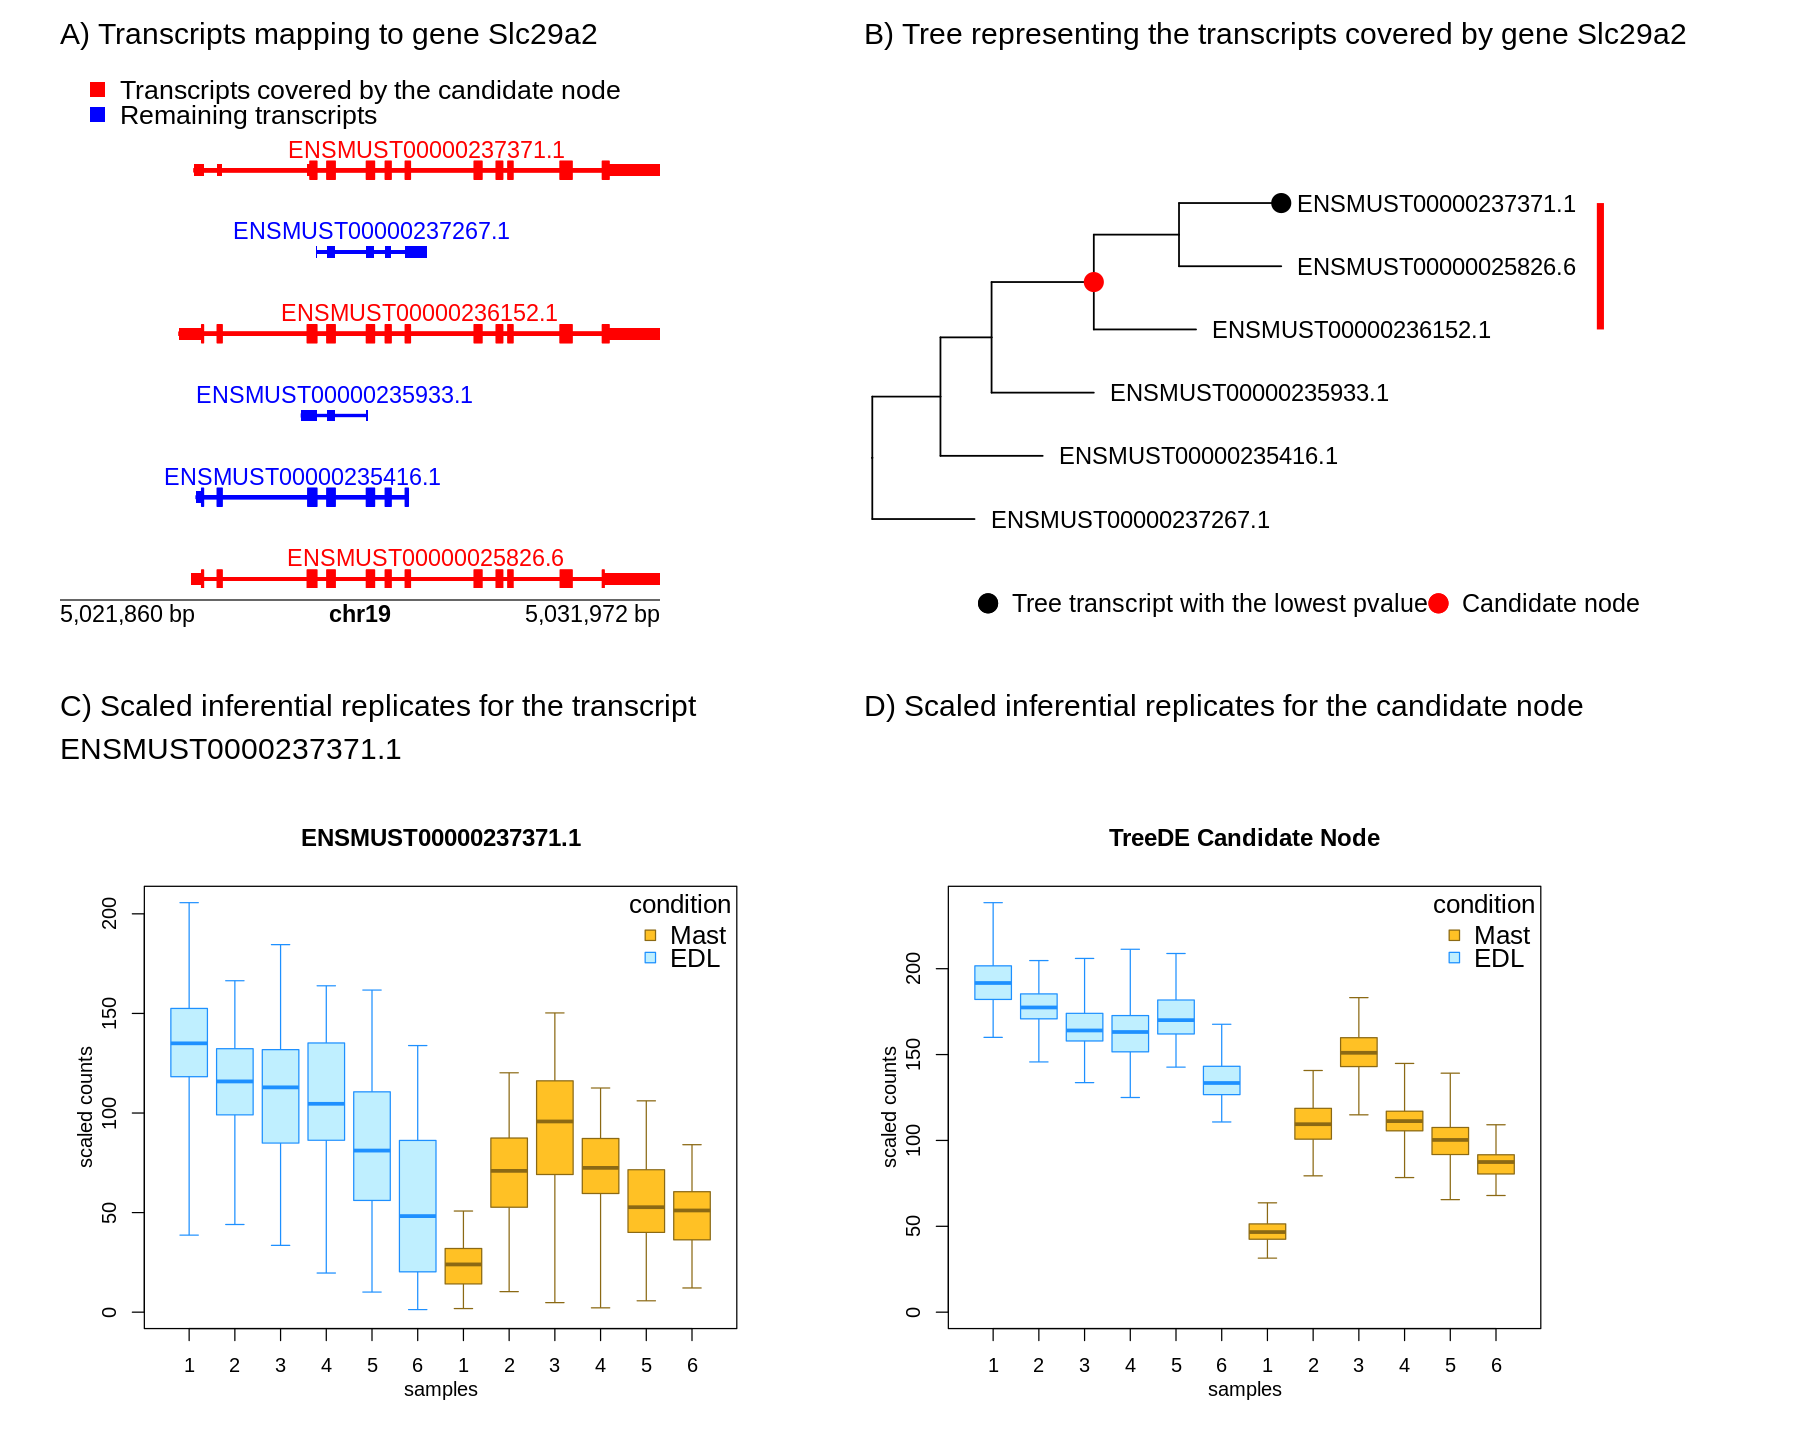

In [47]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotText(label="A) Transcripts mapping to gene Slc29a2", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.9, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Slc29a2", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000237371.1", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [29]:
j <- 385
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000235927.1" "ENSMUST00000087951.6" "ENSMUST00000237240.1"
[4] "ENSMUST00000235921.1"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000048832.9"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr19,10688735,10714627,25893,+,107305,ENSMUSG00000048832


ENSMUSG00000048832.9   ENSMUSG00000048832.9   ENSMUSG00000048832.9 
"ENSMUST00000237240.1" "ENSMUST00000087951.6" "ENSMUST00000235927.1" 
  ENSMUSG00000048832.9   ENSMUSG00000048832.9 
"ENSMUST00000237437.1" "ENSMUST00000235921.1"

[1] 3

[1] TRUE

In [30]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 7
lNode <- 3
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))

text[text1]

legend[legend1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



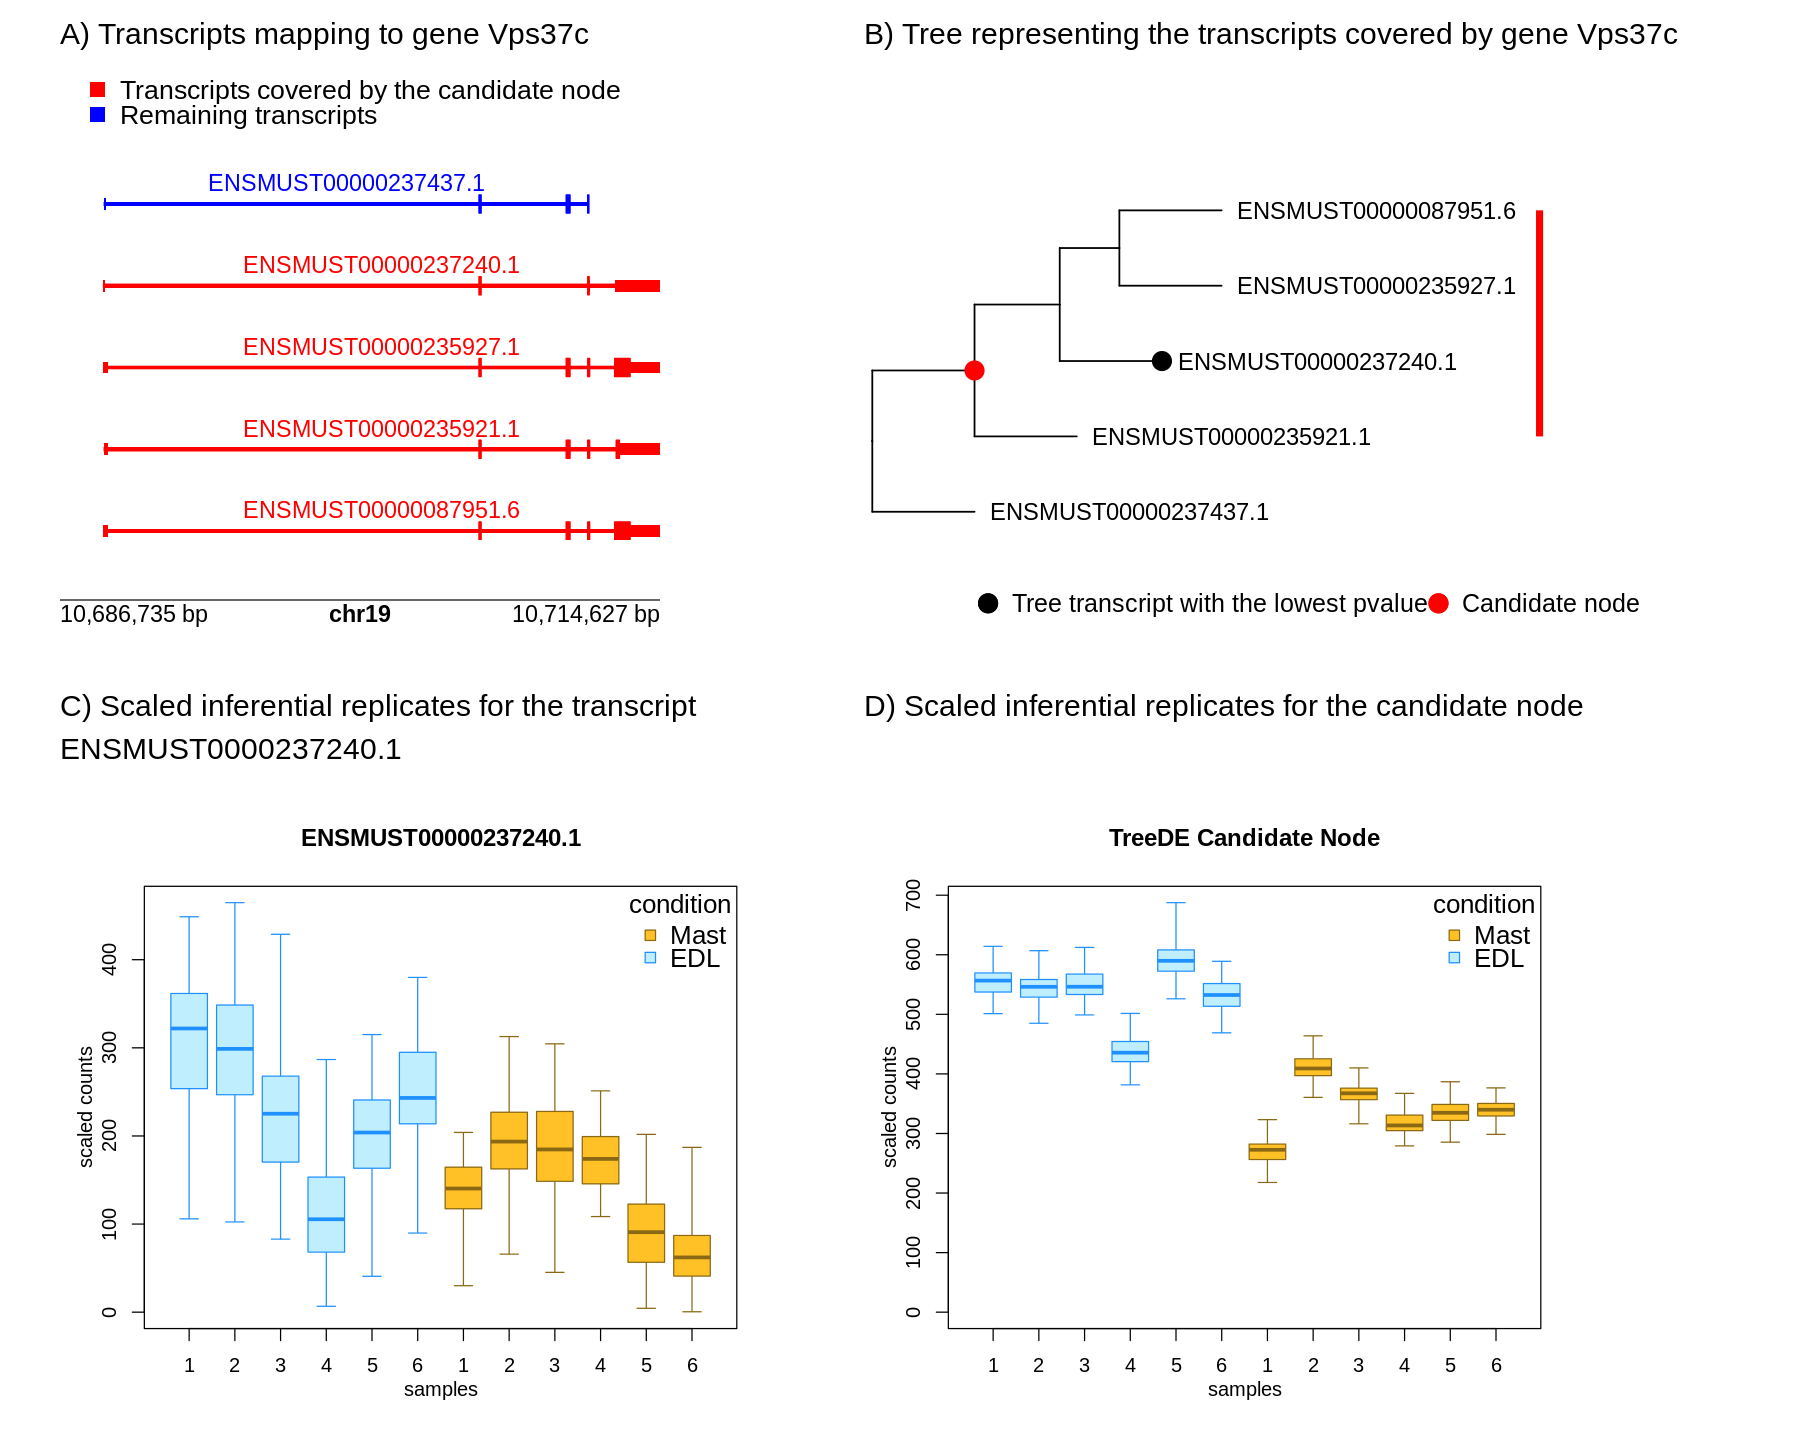

In [37]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotText(label="A) Transcripts mapping to gene Vps37c", x = 0.5, y = 0.2,
        params = parText)
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotTranscripts(
    params = par, x = 0.5, y = 4.5, width = 5, height = 5.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Vps37c", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000237240.1", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [108]:
j <- 14
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000040729.8" "ENSMUST00000160961.7" "ENSMUST00000233633.1"
[4] "ENSMUST00000162862.2"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000036636.10"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr17,25133391,25162104,28714,+,26373,ENSMUSG00000036636


ENSMUSG00000036636.10  ENSMUSG00000036636.10  ENSMUSG00000036636.10 
"ENSMUST00000162862.2" "ENSMUST00000040729.8" "ENSMUST00000233633.1" 
 ENSMUSG00000036636.10  ENSMUSG00000036636.10  ENSMUSG00000036636.10 
"ENSMUST00000162722.1" "ENSMUST00000160961.7" "ENSMUST00000159773.1" 
 ENSMUSG00000036636.10 
"ENSMUST00000159426.1"

[1] 2

[1] TRUE

In [117]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 11
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))

text[text1]

legend[legend1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



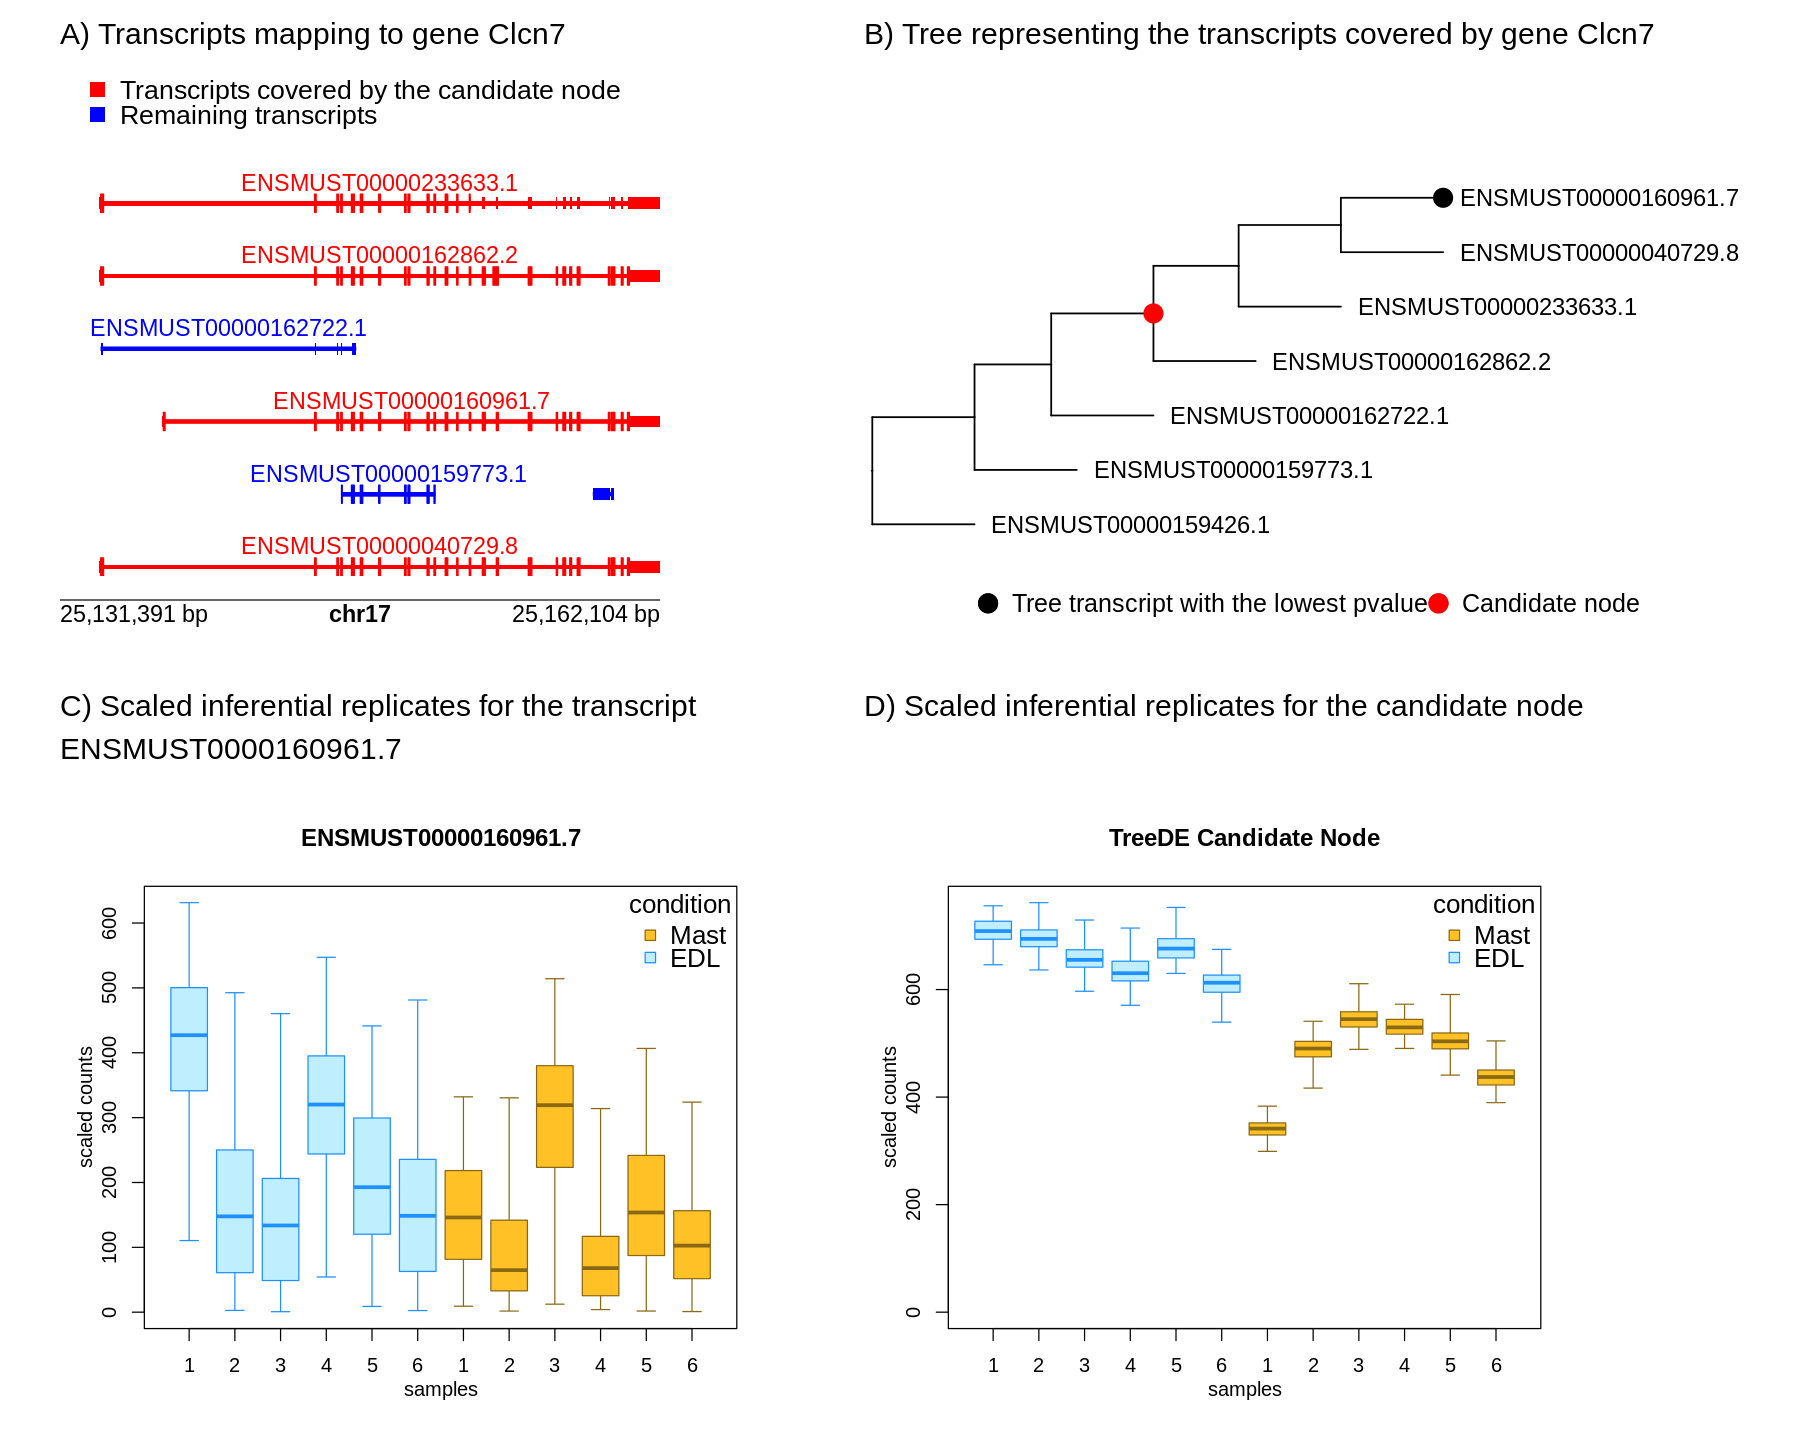

In [119]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotText(label="A) Transcripts mapping to gene Clcn7", x = 0.5, y = 0.2,
        params = parText)
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotTranscripts(
    params = par, x = 0.5, y = 4.8, width = 5, height = 5.5, 
    spaceHeight=2.0, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 5, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Clcn7", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1.3, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000160961.7", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)

In [124]:
j <- 79
i <- 3
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)


gs <- unlist(mapDf[treeSub$tip, "gene_id"])
length(unique(gs))==1
gTxps <- unlist(rowData(yg)[gs[1],"tx_ids"])

all(treeSub$tip %in% gTxps)
all(gTxps %in% treeSub$tip)
all(gTxps %in% treeCons$tip)

unique(gs)
gFilt <- gsub("\\.+\\d+", "", gs[1])
g <- genesMouse %>% 
    filter(ensID == gFilt) %>%
    as_tibble()
g

gTxps
txp_min <- tx_to_show[which.min(mcols(y)[tx_to_show, "pvalue"])]
match(txp_min, treeSub$tip.label)
txp_min %in% tx_to_show

[1] "ENSMUST00000096194.8" "ENSMUST00000025663.7"

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "ENSMUSG00000024754.13"

seqnames,start,end,width,strand,gene_id,ensID
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>
chr19,21778342,21858360,80019,+,83921,ENSMUSG00000024754


ENSMUSG00000024754.13  ENSMUSG00000024754.13  ENSMUSG00000024754.13 
"ENSMUST00000096194.8" "ENSMUST00000236506.1" "ENSMUST00000025663.7" 
 ENSMUSG00000024754.13  ENSMUSG00000024754.13 
"ENSMUST00000237802.1" "ENSMUST00000238079.1"

[1] 2

[1] TRUE

In [125]:
options(repr.plot.width=14, repr.plot.height=9)
of=36.5
inNode <- 8
lNode <- match(txp_min, treeSub$tip.label)
pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
    xlim(NA, 100) +
    geom_tiplab(size=5, hjust=-0.05) +
    geom_point2(aes(subset=(node==inNode), color="red"), 
            size=5, fill='red', show.legend=T) +
    geom_point2(aes(subset=(node==lNode), color = "black"), 
            size=5, fill='black', show.legend=T) +
    geom_cladelab(node = inNode, label = "", textcolour="red", barsize=2,
                  barcolour="red",  fontsize=5, offset = of) + 
    geom_cladelab(node = lNode, label = "", textcolour="black",
                  fontsize=5, offset = of+4) +
    theme(legend.position = "bottom", legend.text=element_text(size=15),
         plot.title=element_text(size=16, face="bold", hjust=0.5)) +
    scale_color_manual(name = "", labels=c("Tree transcript with the lowest pvalue", "Candidate node"),
           values=c("black", "red"))


pTxp <- as.grob(~plotInfReps(y, txp_min, x = "condition", legend = TRUE,
                        legendTitle=TRUE, legendCex=1.3,
                       legendPos = "topright"))
pInn <- as.grob(~plotInfReps(yAll, iNode, x = "condition", legend=TRUE,
                              main="TreeDE Candidate Node", legendTitle=TRUE, legendCex=1.3,
                             legendPos = "topright"))

text[text1]

legend[legend1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



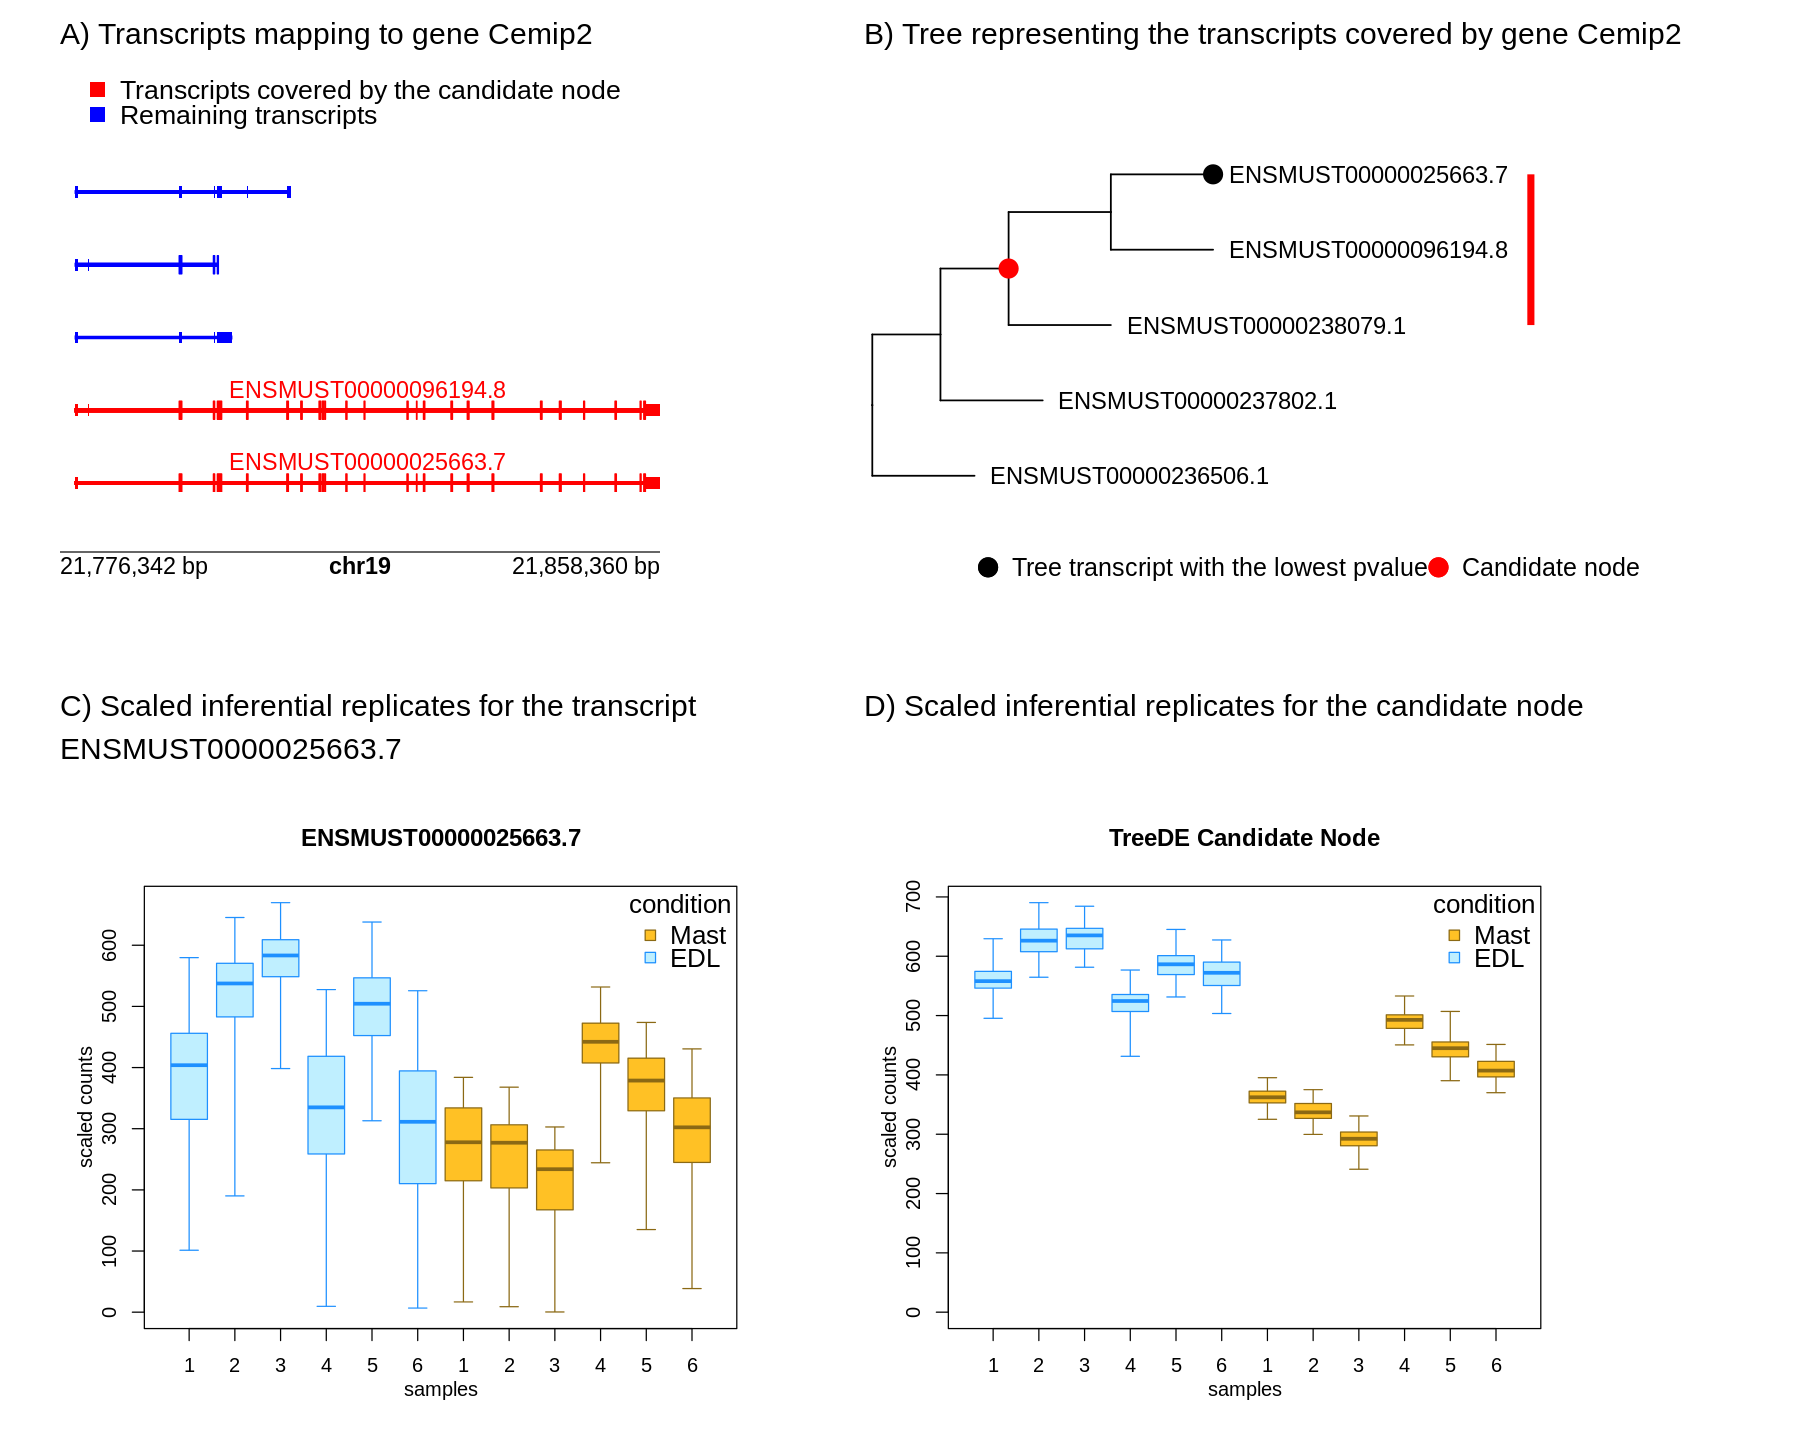

In [129]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = as.character(g[["seqnames"]]), 
  chromstart = g[["start"]]-2000, chromend = g[["end"]],
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=c(tx_to_show, setdiff(treeSub$tip, tx_to_show)), 
                     color=c(rep("red", length(tx_to_show)),
                             rep("blue", length(setdiff(treeSub$tip, tx_to_show)))))
plotText(label="A) Transcripts mapping to gene Cemip2", x = 0.5, y = 0.2,
        params = parText)
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.6, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=16,
)
plotTranscripts(
    params = par, x = 0.5, y = 4.1, width = 5, height = 5.5, 
    spaceHeight=2.0, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 4.6, length=5,
  just = c("left", "top")
)

plotText(label="B) Tree representing the transcripts covered by gene Cemip2", 
         x = 7.2, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y = 1, width = 8, height=4
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST0000025663.7", 
         x = 0.5, y = 5.8, params = parText)

plotGG(
    plot = pTxp,
    x = 0.5, y = 6.8, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.2, y = 5.8, params = parText)

plotGG(
    plot = pInn,
    x = 7.2, y = 6.8, width = 6, height=5
)